# TV Script Generation
In this notebook, we'll construct an RNN model to generate television scripts for a TV show. 

The notebook implements some ideas found from [this /r/machinelearning post](https://www.reddit.com/r/MachineLearning/comments/3psqil/sentence_to_sentence_text_generation_using_lstms/), [this paper on applying dropout to LSTM units](https://arxiv.org/pdf/1409.2329.pdf), and [this paper on output embedding for language models](https://arxiv.org/pdf/1409.2329.pdf).

In [1]:
import torch

GPU_AVAILABLE = torch.cuda.is_available()
GPU_AVAILABLE

True

## Preprocessing the data

To start, we can use the [The Simpsons by the Data](https://www.kaggle.com/wcukierski/the-simpsons-by-the-data) dataset from Kaggle.

The tv scripts are originally in .csv format, but since we're only going to train our model on the raw text of the scripts, I've converted the .csv into a simple text file, [here](./data/simpsons/simpsons_script_lines.txt). 

I've also split the original dataset into 50% [training](./data/simpsons/train.txt), 25% [testing](./data/simpsons/test.txt), and 25% [validation](valid.txt) sets.

In [2]:
%%bash
tail ./data/simpsons/simpsons_script_lines.txt

Marge Simpson: Yes.
Lisa Simpson: Can we do it this week?
(Springfield Elementary School: INT. ELEMENTARY - HALLWAY)
Lisa Simpson: (REHEARSING) Mr. Bergstrom, we request the pleasure of your company... no... Mr. Bergstrom, if you're not doing anything this Friday... no... Mr. Bergstrom, do you like pork chops... oh no, of course you wouldn't...
Miss Hoover: Good morning, Lisa.
Miss Hoover: (OFF LISA'S REACTION) I'm back.
Miss Hoover: You see, class, my Lyme disease turned out to be...
Miss Hoover: Psy-cho-so-ma-tic.
Ralph Wiggum: Does that mean you were crazy?
JANEY: No, that means she was faking it.

In the snippet above, there are three instances of the word `no`. Unfortunately, when we start adding words to our dictionary, `no...` and `no,` will be treated as entirely different words. To remedy this, we can create a token lookup function to map special characters to their own words:

In [3]:
def token_lookup():
    return {
        '.': '||period||',
        ',': '||comma||',
        '"': '||quotation_mark||',
        ';': '||semicolon||',
        '!': '||exclamation_mark',
        '?': '||question_mark',
        '(': '||l_parantheses||',
        ')': '||r_parantheses||',
        '-': '||dash||',
        '\'': '||apostrophe||',
        '\n': '||return||'
    }

### Dictionary Class
The Dictionary can hold our text encodings for later referral. It will also have a helper function to easily query the number of words and to add words to the dictionary instance.

In [4]:
import os
import torch

class Dictionary(object):
    def __init__(self):
        self.word_to_idx = {}
        self.idx_to_word = []
        
    def add_word(self, word):
        if word not in self.word_to_idx:
            self.idx_to_word.append(word)
            self.word_to_idx[word] = len(self.idx_to_word) -1
        return self.word_to_idx[word]
    
    def __len__(self):
        return len(self.idx_to_word)

### Corpus Class
The Corpus can contain the training, testing, and validation sets for the model, as well as a dictionary of words. The corpus is capable of tokenizing its data to help with punctuation and capitalization. Note that the tokenization adds delimeters around the tokenized punctuation.

In [5]:
class Corpus(object):
    def __init__(self, path):
        self.dictionary = Dictionary()
        self.train = self.tokenize(os.path.join(path, 'train.txt'))
        self.test = self.tokenize(os.path.join(path, 'test.txt'))
        self.valid = self.tokenize(os.path.join(path, 'valid.txt'))
        
    def tokenize(self, path):
        assert os.path.exists(path), "Could not find file matching %s" % path
        
        # Add words to the diictionary
        with open(path, 'r') as f:
            tokens = 0
            for line in f:
                for key, tok in token_lookup().items():
                    line = line.replace(key, ' {} '.format(tok))
                line = line.lower()
                
                words = line.split() + ['||return||']
                tokens += len(words)
                
                for word in words:
                    self.dictionary.add_word(word)
        
        # Tokenize the words and return a LongTensor of ids
        with open(path, 'r') as f:
            ids = torch.LongTensor(tokens)
            token = 0
            for line in f:
                for key, tok in token_lookup().items():
                    line = line.replace(key, ' {} '.format(tok))
                line = line.lower()
                words = line.split() + ['||return||']
                
                for word in words:
                    ids[token] = self.dictionary.word_to_idx[word]
                    token += 1
        return ids            

### Load the Data
With those two classes, we can actually load our data:

In [6]:
pathname = './data/simpsons/'
corpus = Corpus(pathname)

### Batch the data
We need to split up our data into batches for training. We can do so with a batchify method like so:

In [7]:
def batchify(data, batch_size):
    # Work out how cleanly we can divide the dataset into :batch_size: parts
    n_batches = data.size(0) // batch_size
    
    # Trim off any extra elements that wouldn't cleanly fit (remainders)
    data = data.narrow(0, 0, n_batches * batch_size)
    
    # Evenly divide the data across the :batch_size: batches.
    data = data.view(batch_size, -1).t().contiguous()
    
    if GPU_AVAILABLE:
        data = data.cuda()
    
    return data

In [8]:
evaluation_batch_size = 10
batch_size = 20
train_data = batchify(corpus.train, batch_size)
test_data = batchify(corpus.test, evaluation_batch_size)
validation_data = batchify(corpus.valid, evaluation_batch_size)
n_tokens = len(corpus.dictionary)

## Build the Model

In [9]:
import torch.nn as nn
from torch.autograd import Variable

class RNNModel(nn.Module):
    def __init__(self, n_tokens, n_inputs, n_hidden, n_layers, dropout=0.5):
        super(RNNModel, self).__init__()
        
        # Randomly zeroes some of the elements of
        #  the input tensor with probability :dropout:
        #  using samples from a bernoulli distribution
        self.dropout = nn.Dropout(dropout)
        
        # A simple lookup table that stores embeddings 
        #  of a fixed dictionary and size.
        # We are using it to store word embeddings
        self.encoder = nn.Embedding(n_tokens, n_inputs)
        
        # A multi-layer long short-term memory cell
        self.rnn = nn.LSTM(n_inputs, n_hidden, n_layers, dropout=dropout)
        
        # A layer to apply a linear transformation to the incoming data
        self.decoder = nn.Linear(n_hidden, n_tokens)
        
        self.init_weights()
        
        self.n_hidden = n_hidden
        self.n_layers = n_layers
        
    def init_weights(self):
        # Initialize the weights of our encoder and decoder with random 
        #  values sampled from a uniform distribution over (-0.1, 0.1).
        # Also set the bias of our linear transformation to 0
        initrange = 0.1
        self.encoder.weight.data.uniform_(-initrange, initrange)
        self.decoder.bias.data.fill_(0)
        self.decoder.weight.data.uniform_(-initrange, initrange)
        
    def forward(self, input, hidden):
        # At every call, run the input through here
        embedding = self.dropout(self.encoder(input))
        output, hidden = self.rnn(embedding, hidden)
        output = self.dropout(output)
        decoded = self.decoder(output.view(output.size(0)*output.size(1), output.size(2)))
        return decoded.view(output.size(0), output.size(1), decoded.size(1)), hidden
    
    def init_hidden(self, batch_size):
        # Initialize the hidden layer with zeros
        weight = next(self.parameters()).data
        
        return (
            Variable(weight.new(self.n_layers, batch_size, self.n_hidden).zero_()),
            Variable(weight.new(self.n_layers, batch_size, self.n_hidden).zero_())
        )

### Define the Hyperparameters

In [10]:
embedding_size = 1500
num_hidden = 650
dropout_probability = 0.6
num_epochs = 25
num_layers = 2
num_tokens = len(corpus.dictionary)
sequence_length = 40
learning_rate = 10.0
gradient_clipping = 0.3
logging_interval = 250

### Build the Model

In [11]:
model = RNNModel(num_tokens, embedding_size, num_hidden, num_layers, dropout_probability)

if GPU_AVAILABLE:
    model.cuda()

### Define our Criterion
We will calculate loss based off of PyTorch's `nn.CrossEntropyLoss`. This criterion performs a `Log(SoftMax(x))` function to a tensor, and passes the result to a negative log likelihood function.

In [12]:
criterion = nn.CrossEntropyLoss()

## Train the Model

`repackage_hidden_states` detaches variables from their history to avoid backpropogating through the entire training history

In [13]:
def repackage_hidden_states(h):
    if type(h) == Variable:
        return Variable(h.data)
    else:
        return tuple(repackage_hidden_states(v) for v in h)

`get_batch` gets a batch to use in each training or evaluation pass

In [14]:
def get_batch(source, i, evaluation=False):
    sequence_len = min(sequence_length, len(source)-1-i)
    data = Variable(source[i:i+sequence_len], volatile=evaluation)
    target = Variable(source[i+1:i+1+sequence_len].view(-1))
    
    return data, target

`evaluate` Turns on evaluation mode, which disables dropout.

In [15]:
def evaluate(data_source):
    model.eval()
    total_loss = 0
    ntok = len(corpus.dictionary)
    hidden = model.init_hidden(evaluation_batch_size)
    
    for i in range(0, data_source.size(0) -1, sequence_length):
        data, targets = get_batch(data_source, i, evaluation=True)
        output, hidden = model(data, hidden)
        output_flat = output.view(-1, ntok)
        total_loss += len(data) * criterion(output_flat, targets).data
        hidden = repackage_hidden_states(hidden)
    return total_loss[0] / len(data_source)

In [16]:
import math
import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter, FormatStrFormatter 

def train():
    lr = learning_rate
    best_validation_loss = None
    iteration = 0
    losses = np.zeros(0)
    learning_rates = np.zeros(0)
    
    for epoch in range(1, num_epochs+1):
        epoch_start_time = time.time()
        
        model.train()
        total_loss = 0
        n_tokens = len(corpus.dictionary)
        hidden = model.init_hidden(batch_size)
        start_time = time.time()

        for batch, i in enumerate(range(0, train_data.size(0) - 1, sequence_length)):
            iteration += 1
            data, targets = get_batch(train_data, i)

            hidden = repackage_hidden_states(hidden)
            model.zero_grad()
            output, hidden = model(data, hidden)
            loss = criterion(output.view(-1, n_tokens), targets)
            loss.backward()

            # clip_grad_norm prevents the exploding gradient problem in RNNs and LSTMs
            torch.nn.utils.clip_grad_norm(model.parameters(), gradient_clipping)

            for p in model.parameters():
                p.data.add_(-lr, p.grad.data)

            total_loss += loss.data
            losses = np.resize(losses, iteration)
            learning_rates = np.resize(learning_rates, iteration)
            np.put(losses, [iteration-1], [loss.data[0]])
            np.put(learning_rates, [iteration-1], [lr])

            if batch % logging_interval == 0 and batch > 0 and iteration > 10:
                current_loss = total_loss[0] / logging_interval
                elapsed = time.time() - start_time
                print('Epoch {}/{} batches: {}/{} lr {:.2f}, loss {:.2f}, perplexity: {:.2f}'.format(
                        epoch, num_epochs, batch, len(train_data) // sequence_length, lr, current_loss, math.exp(current_loss))
                     )
                iterations = np.arange(iteration)
                first_clip = np.arange(1)
                max_p = losses.copy().data[0] + (losses.data[0]/6)
                max_lr = learning_rates.copy().data[0] + (learning_rates.data[0]/6)
                
                fig, ax1 = plt.subplots()
                ax2 = ax1.twinx()
                ax1.set_xlabel('Iteration #')
                ax1.set_ylabel('Loss')
                ax2.set_ylabel('Learning Rate')
                ax2.set_ylim([0, max_lr])
                ax1.set_ylim([0, max_p])

                
                if(iteration == 11):
                    iterations = np.delete(iterations, first_clip)
                    losses = np.delete(losses, first_clip)
                    learning_rates = np.delete(learning_rates, first_clip)
                
                ax1.plot(iterations, losses, 'b-')
                ax2.plot(iterations, learning_rates, 'g-')
            
                plt.show()
                
                total_loss = 0
        validation_loss = evaluate(validation_data)
        
        print('='*76)
        print('Epoch {:3d} results: time: {:5.2f}s, validation loss {:5.2f}, perplexity {:8.2f}'.format(
            epoch, (time.time() - epoch_start_time), validation_loss, math.exp(validation_loss)
        ))
        print('='*76)

        
        # If the model's validation loss is the best we've seen, save the model
        if not best_validation_loss or validation_loss < best_validation_loss:
            with open('model_checkpoint.pt', 'wb') as f:
                torch.save(model, f)
            best_validation_loss = validation_loss
        else:
            # Anneal the learning rate if no improvement has been seen in the validation dataset
            lr /= 4.0

Epoch 1/25 batches: 250/2326 lr 10.00, loss 6.29, perplexity: 536.58


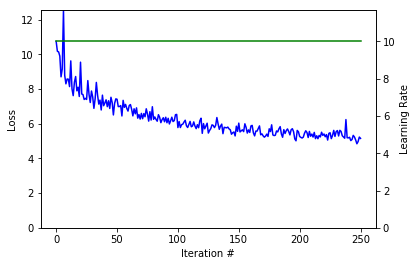

Epoch 1/25 batches: 500/2326 lr 10.00, loss 4.85, perplexity: 127.80


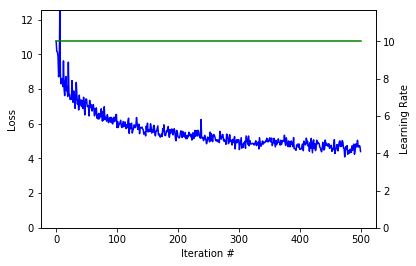

Epoch 1/25 batches: 750/2326 lr 10.00, loss 4.60, perplexity: 99.59


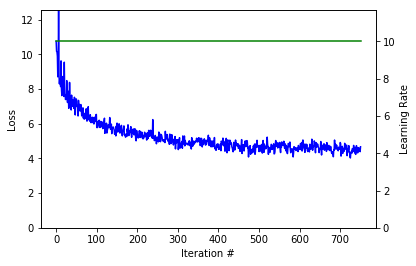

Epoch 1/25 batches: 1000/2326 lr 10.00, loss 4.41, perplexity: 82.04


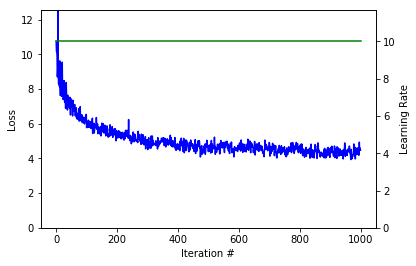

Epoch 1/25 batches: 1250/2326 lr 10.00, loss 4.32, perplexity: 75.43


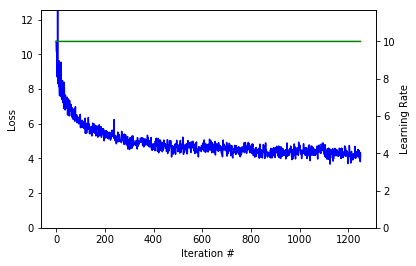

Epoch 1/25 batches: 1500/2326 lr 10.00, loss 4.23, perplexity: 68.40


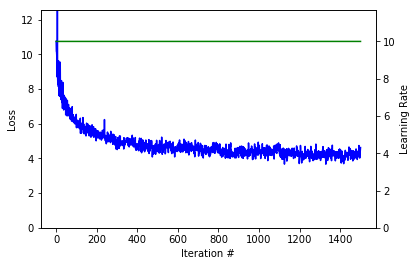

Epoch 1/25 batches: 1750/2326 lr 10.00, loss 4.13, perplexity: 62.44


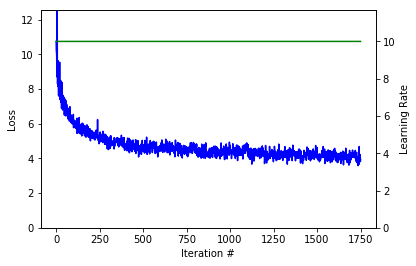

Epoch 1/25 batches: 2000/2326 lr 10.00, loss 4.08, perplexity: 59.09


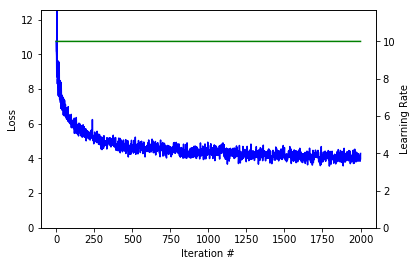

Epoch 1/25 batches: 2250/2326 lr 10.00, loss 4.11, perplexity: 60.75


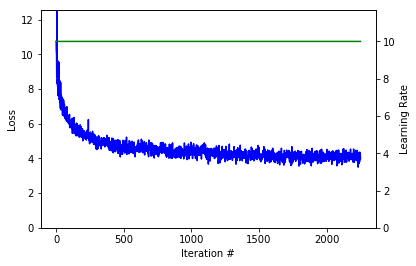

Epoch   1 results: time: 327.05s, validation loss  4.04, perplexity    57.01


/home/tyson/anaconda3/envs/ml/lib/python3.6/site-packages/torch/serialization.py:147: UserWarning: Couldn't retrieve source code for container of type RNNModel. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch 2/25 batches: 250/2326 lr 10.00, loss 4.01, perplexity: 55.00


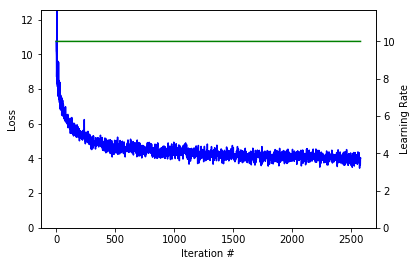

Epoch 2/25 batches: 500/2326 lr 10.00, loss 3.90, perplexity: 49.49


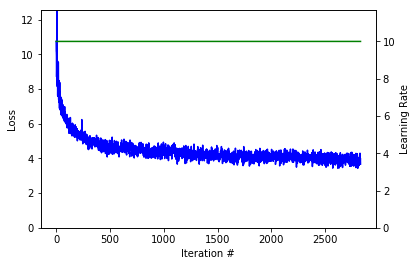

Epoch 2/25 batches: 750/2326 lr 10.00, loss 3.97, perplexity: 53.20


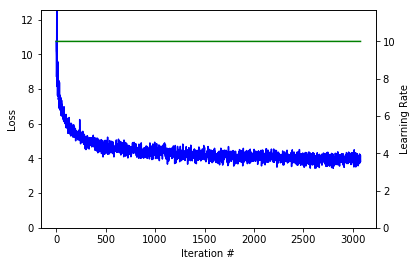

Epoch 2/25 batches: 1000/2326 lr 10.00, loss 3.92, perplexity: 50.43


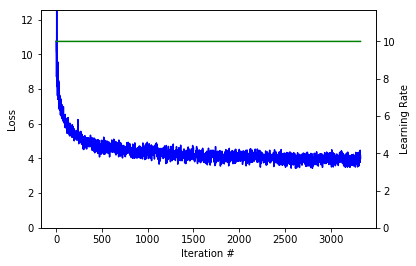

Epoch 2/25 batches: 1250/2326 lr 10.00, loss 3.92, perplexity: 50.38


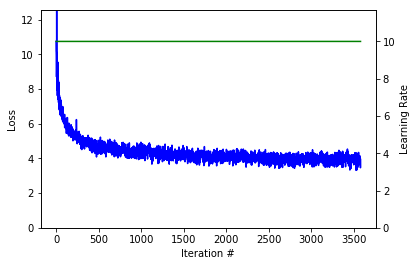

Epoch 2/25 batches: 1500/2326 lr 10.00, loss 3.88, perplexity: 48.33


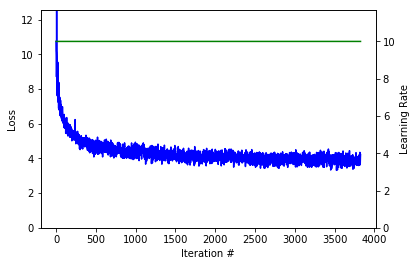

Epoch 2/25 batches: 1750/2326 lr 10.00, loss 3.83, perplexity: 45.97


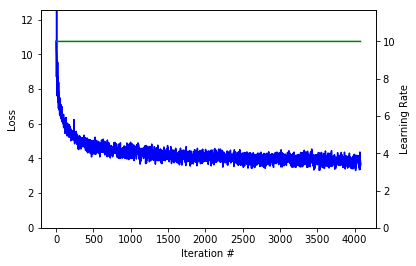

Epoch 2/25 batches: 2000/2326 lr 10.00, loss 3.81, perplexity: 44.99


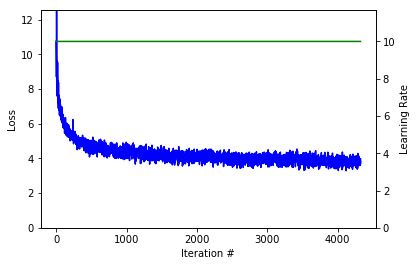

Epoch 2/25 batches: 2250/2326 lr 10.00, loss 3.85, perplexity: 47.10


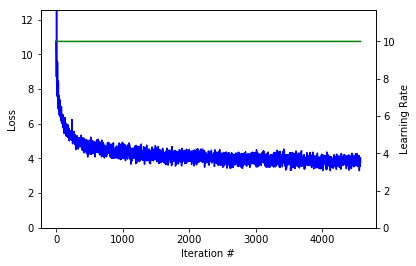

Epoch   2 results: time: 318.08s, validation loss  3.86, perplexity    47.44
Epoch 3/25 batches: 250/2326 lr 10.00, loss 3.79, perplexity: 44.40


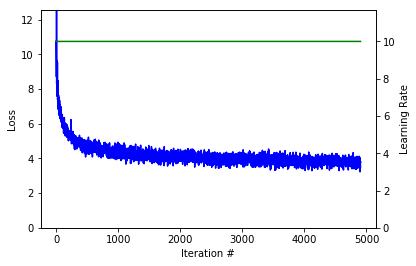

Epoch 3/25 batches: 500/2326 lr 10.00, loss 3.71, perplexity: 40.87


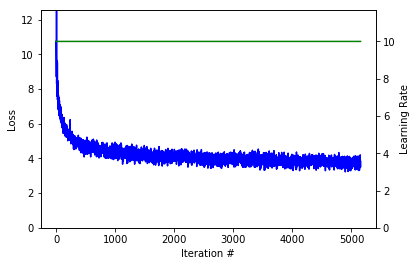

Epoch 3/25 batches: 750/2326 lr 10.00, loss 3.80, perplexity: 44.48


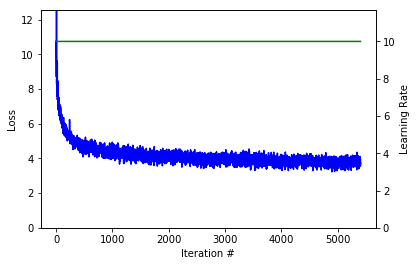

Epoch 3/25 batches: 1000/2326 lr 10.00, loss 3.76, perplexity: 42.87


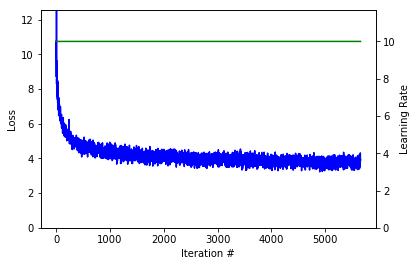

Epoch 3/25 batches: 1250/2326 lr 10.00, loss 3.77, perplexity: 43.25


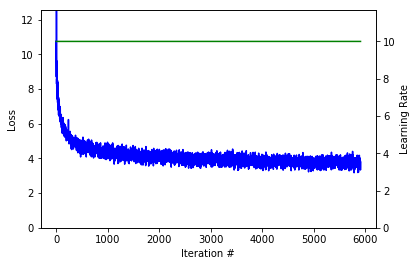

Epoch 3/25 batches: 1500/2326 lr 10.00, loss 3.74, perplexity: 41.90


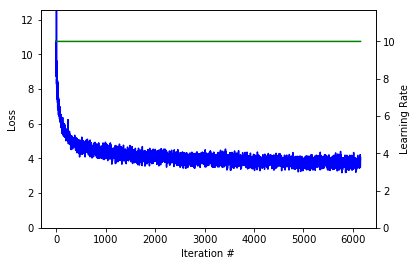

Epoch 3/25 batches: 1750/2326 lr 10.00, loss 3.69, perplexity: 40.11


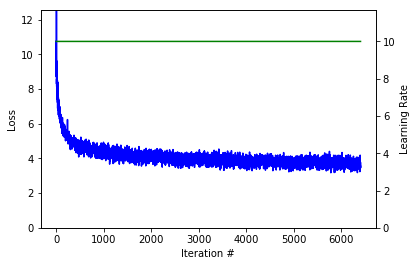

Epoch 3/25 batches: 2000/2326 lr 10.00, loss 3.68, perplexity: 39.58


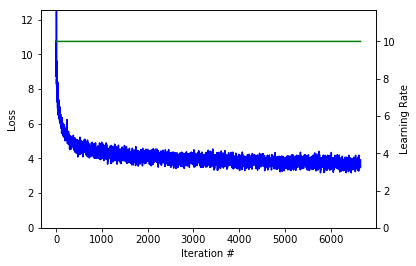

Epoch 3/25 batches: 2250/2326 lr 10.00, loss 3.73, perplexity: 41.49


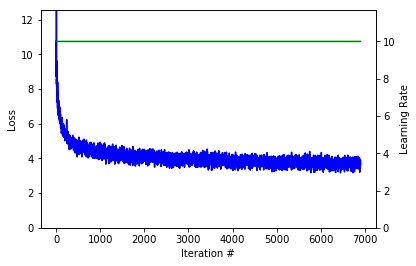

Epoch   3 results: time: 315.62s, validation loss  3.77, perplexity    43.48
Epoch 4/25 batches: 250/2326 lr 10.00, loss 3.68, perplexity: 39.68


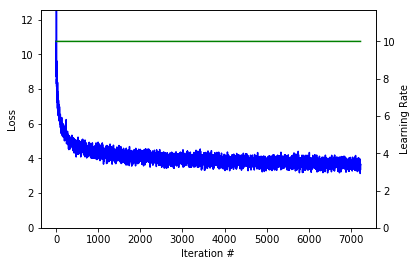

Epoch 4/25 batches: 500/2326 lr 10.00, loss 3.61, perplexity: 36.85


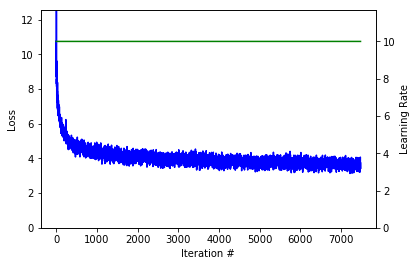

Epoch 4/25 batches: 750/2326 lr 10.00, loss 3.69, perplexity: 40.04


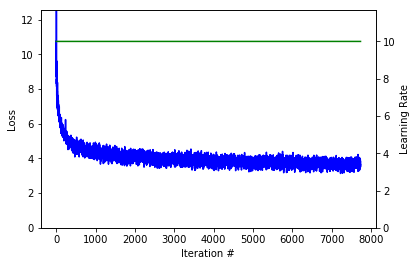

Epoch 4/25 batches: 1000/2326 lr 10.00, loss 3.65, perplexity: 38.62


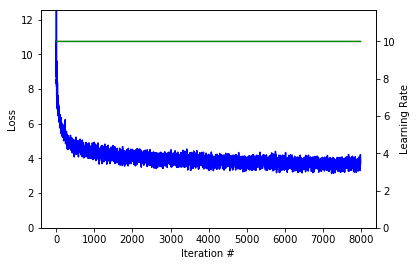

Epoch 4/25 batches: 1250/2326 lr 10.00, loss 3.67, perplexity: 39.14


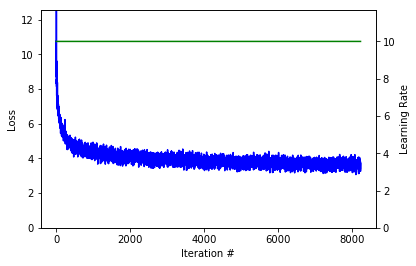

Epoch 4/25 batches: 1500/2326 lr 10.00, loss 3.65, perplexity: 38.36


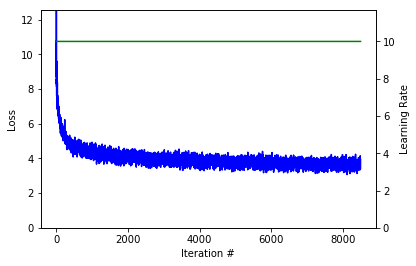

Epoch 4/25 batches: 1750/2326 lr 10.00, loss 3.60, perplexity: 36.64


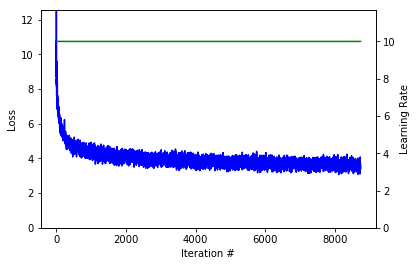

Epoch 4/25 batches: 2000/2326 lr 10.00, loss 3.59, perplexity: 36.37


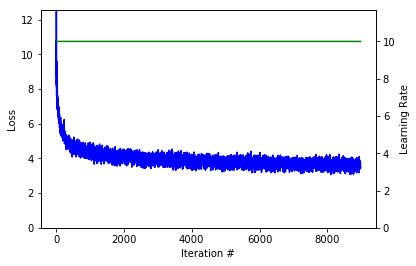

Epoch 4/25 batches: 2250/2326 lr 10.00, loss 3.64, perplexity: 38.07


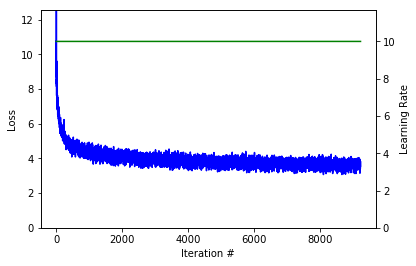

Epoch   4 results: time: 316.65s, validation loss  3.72, perplexity    41.33
Epoch 5/25 batches: 250/2326 lr 10.00, loss 3.60, perplexity: 36.74


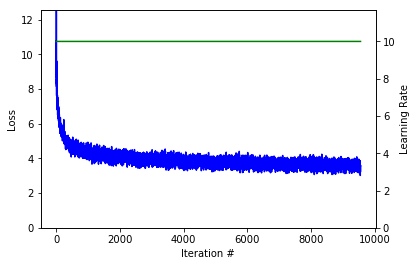

Epoch 5/25 batches: 500/2326 lr 10.00, loss 3.53, perplexity: 34.16


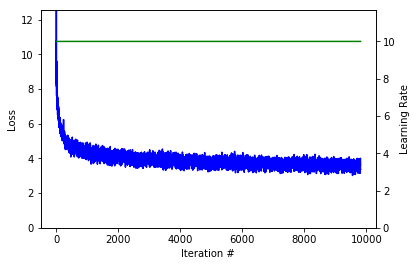

Epoch 5/25 batches: 750/2326 lr 10.00, loss 3.61, perplexity: 36.98


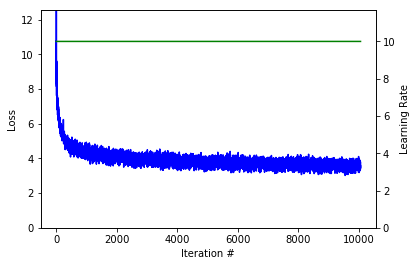

Epoch 5/25 batches: 1000/2326 lr 10.00, loss 3.58, perplexity: 35.96


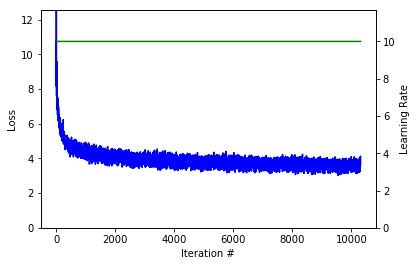

Epoch 5/25 batches: 1250/2326 lr 10.00, loss 3.59, perplexity: 36.32


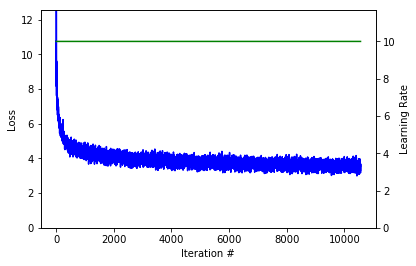

Epoch 5/25 batches: 1500/2326 lr 10.00, loss 3.57, perplexity: 35.60


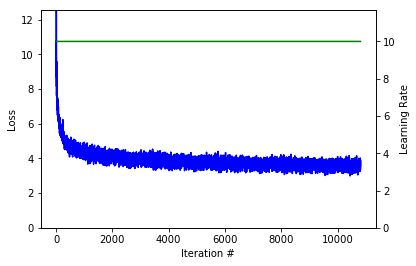

Epoch 5/25 batches: 1750/2326 lr 10.00, loss 3.53, perplexity: 34.26


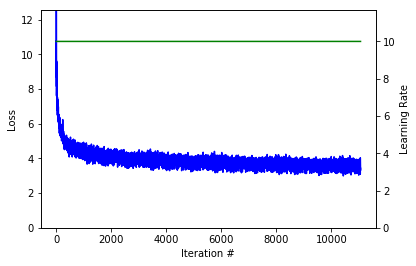

Epoch 5/25 batches: 2000/2326 lr 10.00, loss 3.53, perplexity: 34.05


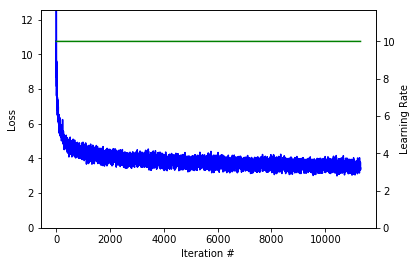

Epoch 5/25 batches: 2250/2326 lr 10.00, loss 3.57, perplexity: 35.66


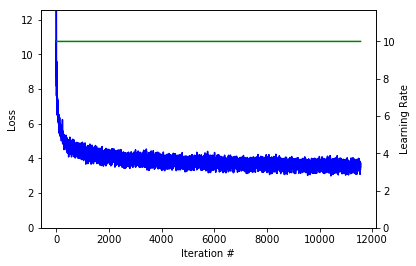

Epoch   5 results: time: 316.75s, validation loss  3.69, perplexity    39.94
Epoch 6/25 batches: 250/2326 lr 10.00, loss 3.54, perplexity: 34.39


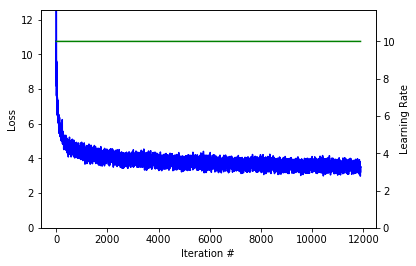

Epoch 6/25 batches: 500/2326 lr 10.00, loss 3.47, perplexity: 32.19


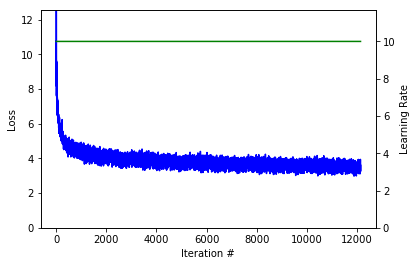

Epoch 6/25 batches: 750/2326 lr 10.00, loss 3.55, perplexity: 34.78


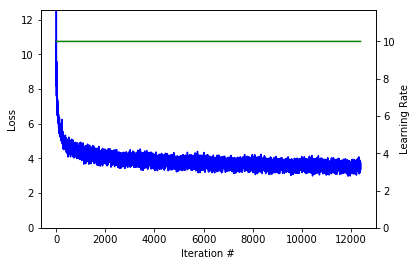

Epoch 6/25 batches: 1000/2326 lr 10.00, loss 3.52, perplexity: 33.75


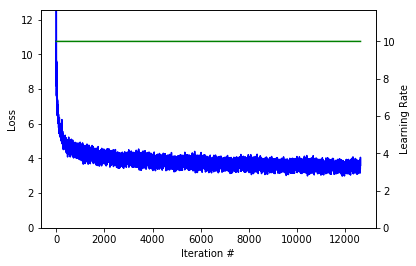

Epoch 6/25 batches: 1250/2326 lr 10.00, loss 3.53, perplexity: 34.27


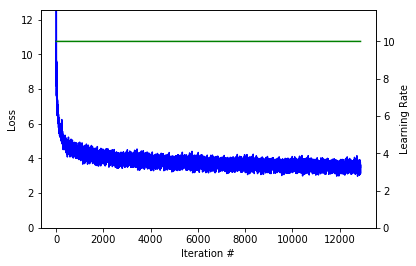

Epoch 6/25 batches: 1500/2326 lr 10.00, loss 3.52, perplexity: 33.64


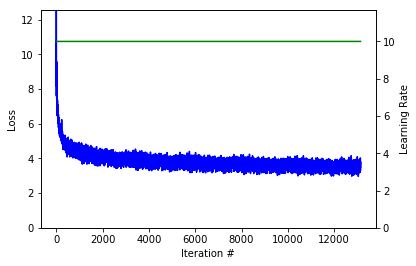

Epoch 6/25 batches: 1750/2326 lr 10.00, loss 3.48, perplexity: 32.43


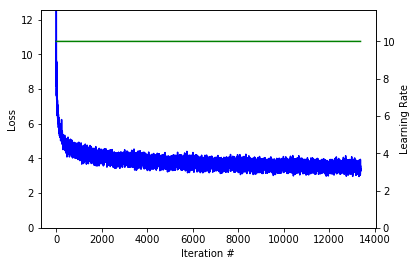

Epoch 6/25 batches: 2000/2326 lr 10.00, loss 3.47, perplexity: 32.20


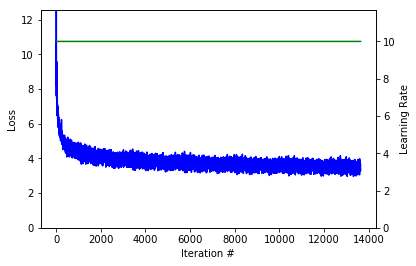

Epoch 6/25 batches: 2250/2326 lr 10.00, loss 3.52, perplexity: 33.74


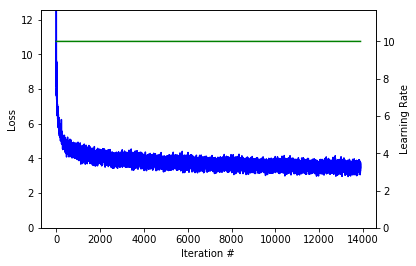

Epoch   6 results: time: 316.96s, validation loss  3.66, perplexity    38.74
Epoch 7/25 batches: 250/2326 lr 10.00, loss 3.49, perplexity: 32.78


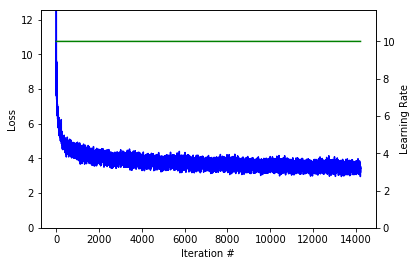

Epoch 7/25 batches: 500/2326 lr 10.00, loss 3.42, perplexity: 30.64


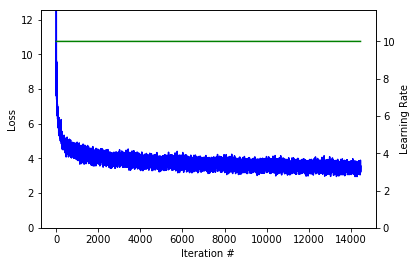

Epoch 7/25 batches: 750/2326 lr 10.00, loss 3.50, perplexity: 33.10


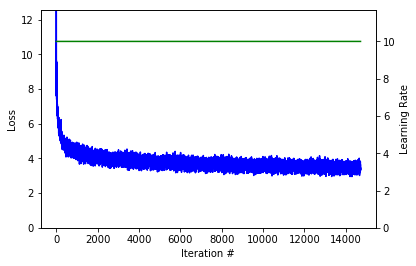

Epoch 7/25 batches: 1000/2326 lr 10.00, loss 3.47, perplexity: 32.27


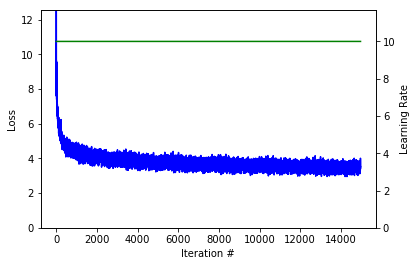

Epoch 7/25 batches: 1250/2326 lr 10.00, loss 3.49, perplexity: 32.69


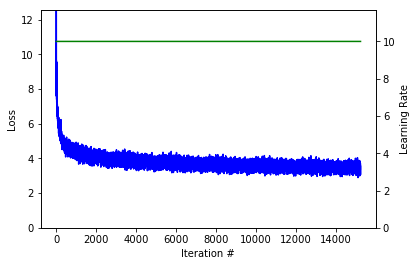

Epoch 7/25 batches: 1500/2326 lr 10.00, loss 3.47, perplexity: 32.10


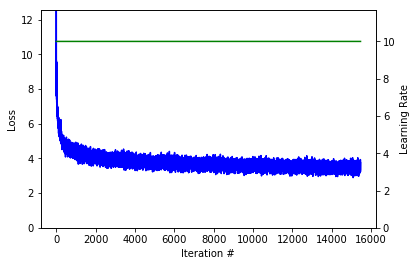

Epoch 7/25 batches: 1750/2326 lr 10.00, loss 3.43, perplexity: 30.93


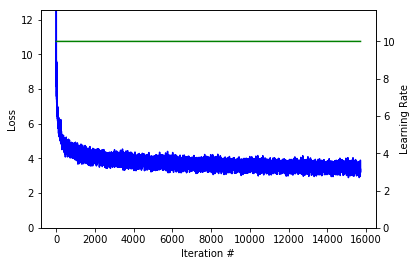

Epoch 7/25 batches: 2000/2326 lr 10.00, loss 3.43, perplexity: 30.81


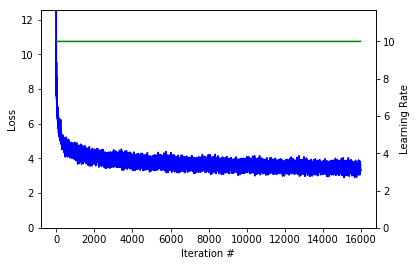

Epoch 7/25 batches: 2250/2326 lr 10.00, loss 3.47, perplexity: 32.24


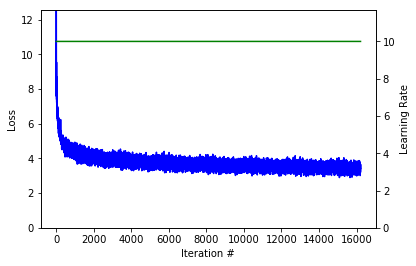

Epoch   7 results: time: 318.53s, validation loss  3.64, perplexity    37.96
Epoch 8/25 batches: 250/2326 lr 10.00, loss 3.44, perplexity: 31.33


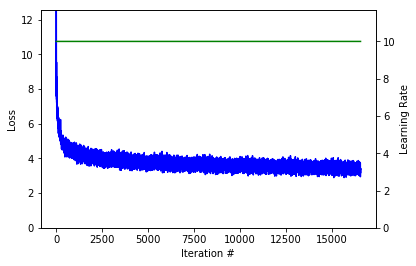

Epoch 8/25 batches: 500/2326 lr 10.00, loss 3.38, perplexity: 29.38


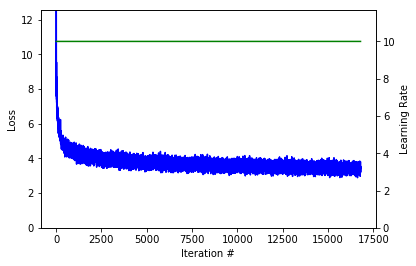

Epoch 8/25 batches: 750/2326 lr 10.00, loss 3.45, perplexity: 31.62


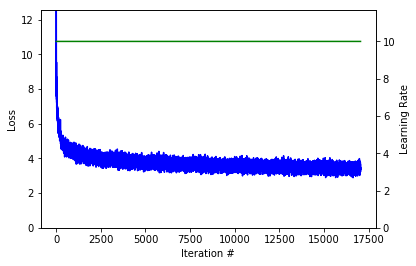

Epoch 8/25 batches: 1000/2326 lr 10.00, loss 3.43, perplexity: 30.75


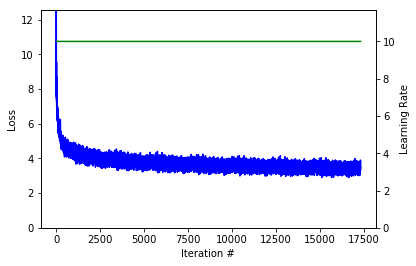

Epoch 8/25 batches: 1250/2326 lr 10.00, loss 3.44, perplexity: 31.25


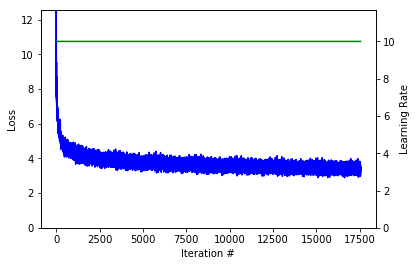

Epoch 8/25 batches: 1500/2326 lr 10.00, loss 3.42, perplexity: 30.69


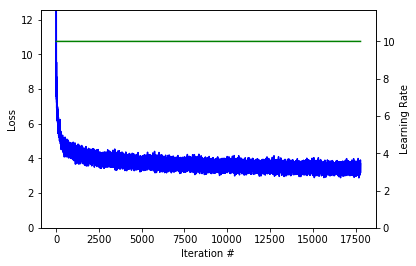

Epoch 8/25 batches: 1750/2326 lr 10.00, loss 3.39, perplexity: 29.64


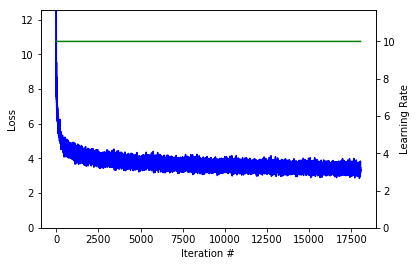

Epoch 8/25 batches: 2000/2326 lr 10.00, loss 3.39, perplexity: 29.67


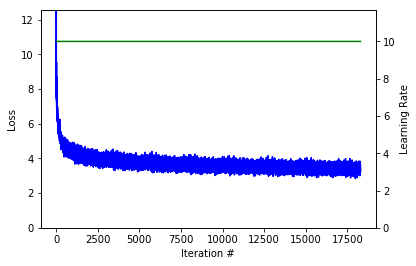

Epoch 8/25 batches: 2250/2326 lr 10.00, loss 3.43, perplexity: 30.99


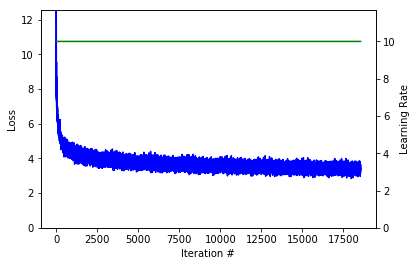

Epoch   8 results: time: 320.24s, validation loss  3.63, perplexity    37.57
Epoch 9/25 batches: 250/2326 lr 10.00, loss 3.40, perplexity: 30.11


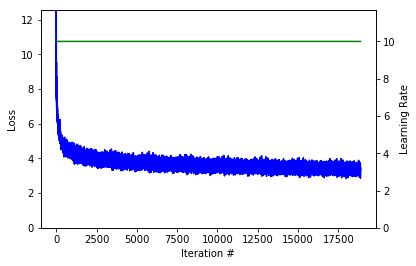

Epoch 9/25 batches: 500/2326 lr 10.00, loss 3.34, perplexity: 28.31


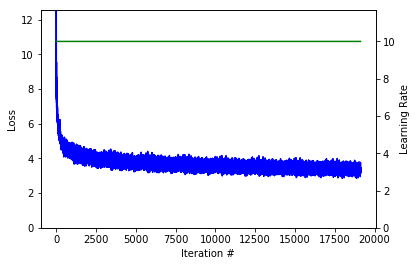

Epoch 9/25 batches: 750/2326 lr 10.00, loss 3.42, perplexity: 30.45


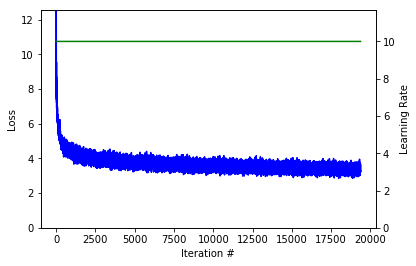

Epoch 9/25 batches: 1000/2326 lr 10.00, loss 3.39, perplexity: 29.69


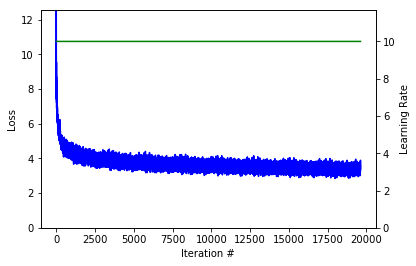

Epoch 9/25 batches: 1250/2326 lr 10.00, loss 3.41, perplexity: 30.15


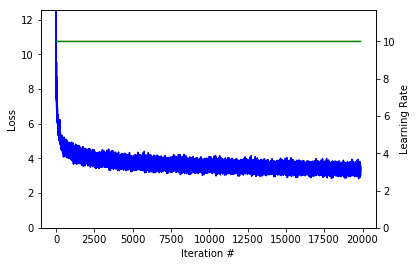

Epoch 9/25 batches: 1500/2326 lr 10.00, loss 3.39, perplexity: 29.67


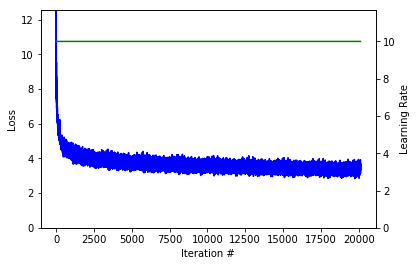

Epoch 9/25 batches: 1750/2326 lr 10.00, loss 3.35, perplexity: 28.55


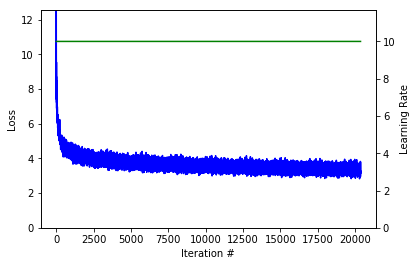

Epoch 9/25 batches: 2000/2326 lr 10.00, loss 3.35, perplexity: 28.60


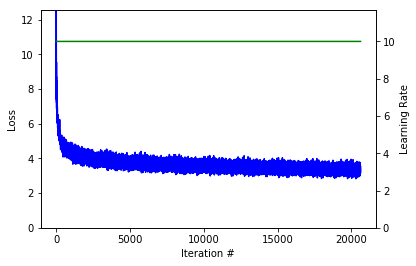

Epoch 9/25 batches: 2250/2326 lr 10.00, loss 3.39, perplexity: 29.80


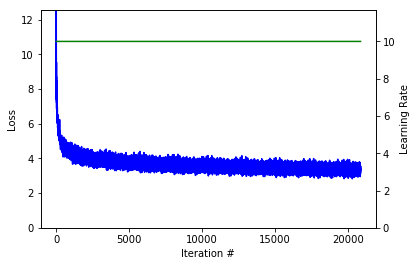

Epoch   9 results: time: 323.38s, validation loss  3.61, perplexity    37.12
Epoch 10/25 batches: 250/2326 lr 10.00, loss 3.37, perplexity: 29.08


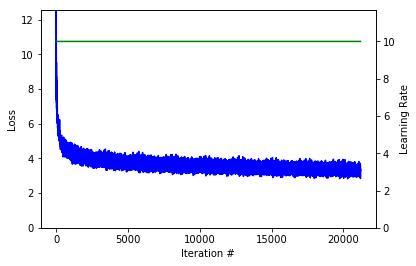

Epoch 10/25 batches: 500/2326 lr 10.00, loss 3.31, perplexity: 27.30


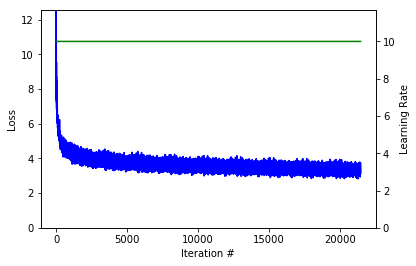

Epoch 10/25 batches: 750/2326 lr 10.00, loss 3.38, perplexity: 29.40


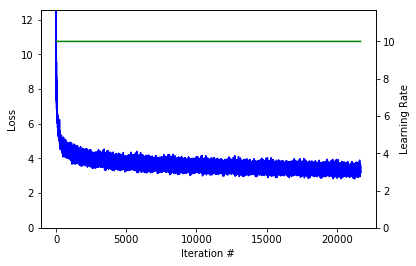

Epoch 10/25 batches: 1000/2326 lr 10.00, loss 3.36, perplexity: 28.68


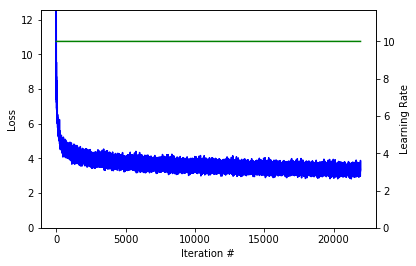

Epoch 10/25 batches: 1250/2326 lr 10.00, loss 3.37, perplexity: 29.17


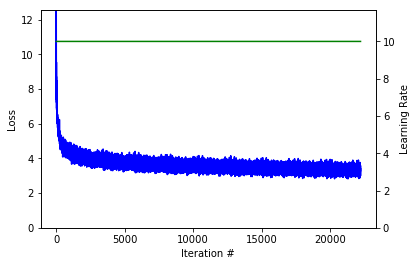

Epoch 10/25 batches: 1500/2326 lr 10.00, loss 3.36, perplexity: 28.69


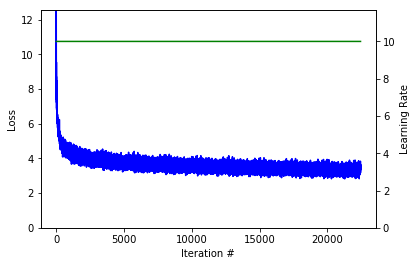

Epoch 10/25 batches: 1750/2326 lr 10.00, loss 3.32, perplexity: 27.71


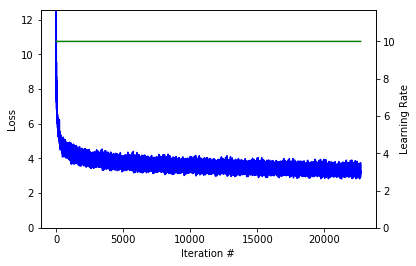

Epoch 10/25 batches: 2000/2326 lr 10.00, loss 3.32, perplexity: 27.71


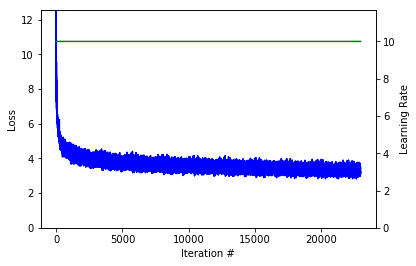

Epoch 10/25 batches: 2250/2326 lr 10.00, loss 3.36, perplexity: 28.85


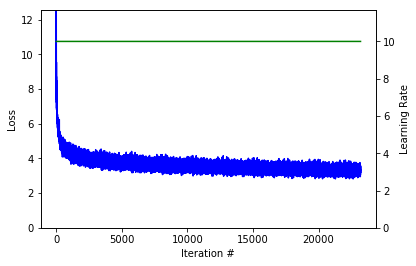

Epoch  10 results: time: 325.52s, validation loss  3.60, perplexity    36.62
Epoch 11/25 batches: 250/2326 lr 10.00, loss 3.34, perplexity: 28.23


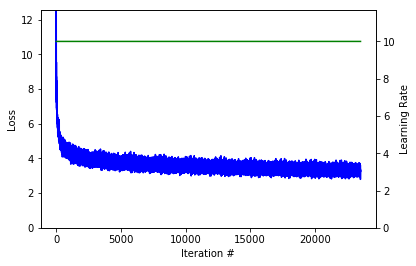

Epoch 11/25 batches: 500/2326 lr 10.00, loss 3.28, perplexity: 26.53


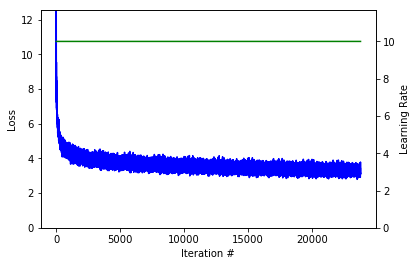

Epoch 11/25 batches: 750/2326 lr 10.00, loss 3.35, perplexity: 28.46


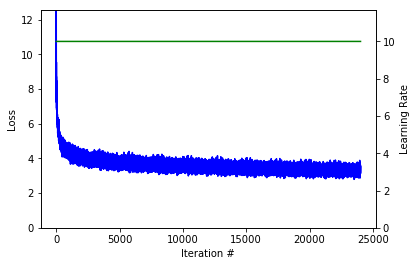

Epoch 11/25 batches: 1000/2326 lr 10.00, loss 3.33, perplexity: 27.86


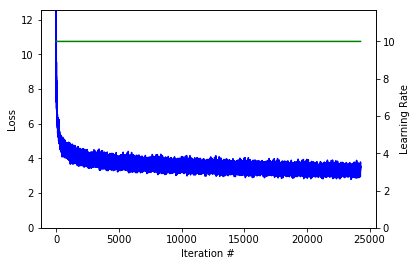

Epoch 11/25 batches: 1250/2326 lr 10.00, loss 3.34, perplexity: 28.27


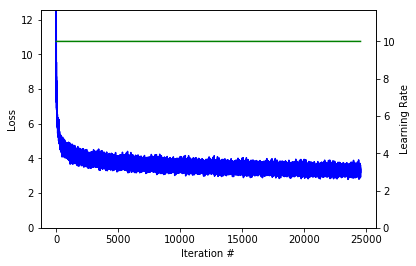

Epoch 11/25 batches: 1500/2326 lr 10.00, loss 3.33, perplexity: 27.87


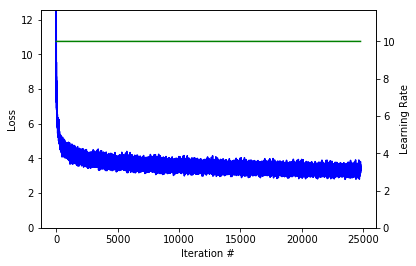

Epoch 11/25 batches: 1750/2326 lr 10.00, loss 3.29, perplexity: 26.87


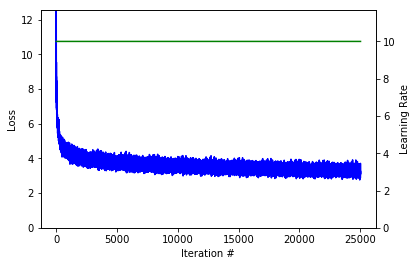

Epoch 11/25 batches: 2000/2326 lr 10.00, loss 3.29, perplexity: 26.85


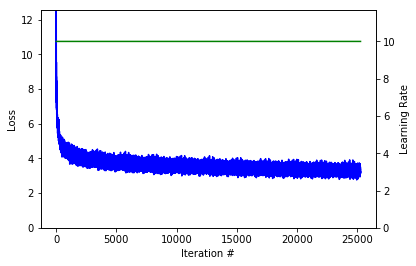

Epoch 11/25 batches: 2250/2326 lr 10.00, loss 3.33, perplexity: 28.04


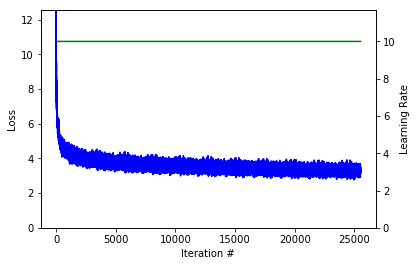

Epoch  11 results: time: 327.67s, validation loss  3.60, perplexity    36.52
Epoch 12/25 batches: 250/2326 lr 10.00, loss 3.31, perplexity: 27.44


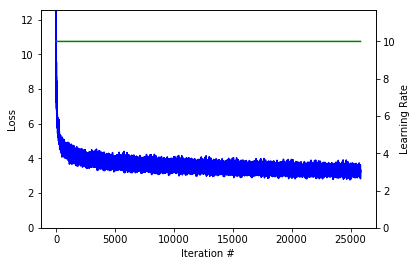

Epoch 12/25 batches: 500/2326 lr 10.00, loss 3.25, perplexity: 25.88


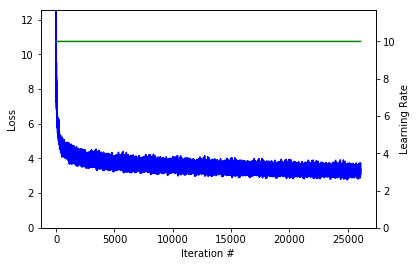

Epoch 12/25 batches: 750/2326 lr 10.00, loss 3.32, perplexity: 27.61


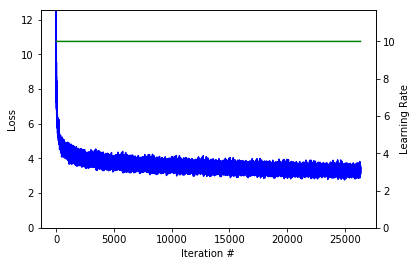

Epoch 12/25 batches: 1000/2326 lr 10.00, loss 3.30, perplexity: 27.09


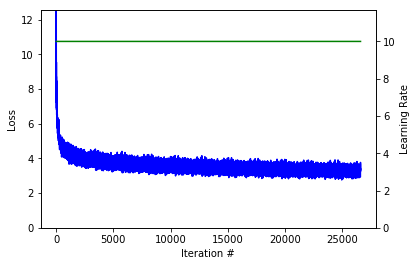

Epoch 12/25 batches: 1250/2326 lr 10.00, loss 3.31, perplexity: 27.45


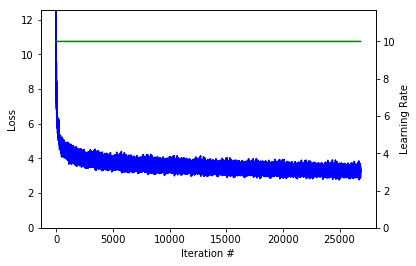

Epoch 12/25 batches: 1500/2326 lr 10.00, loss 3.30, perplexity: 27.04


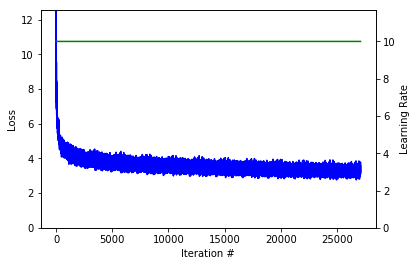

Epoch 12/25 batches: 1750/2326 lr 10.00, loss 3.26, perplexity: 26.15


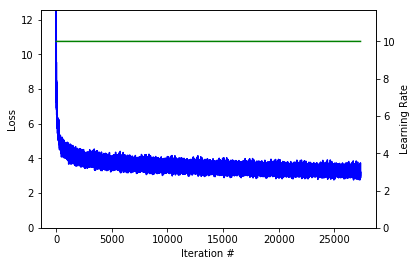

Epoch 12/25 batches: 2000/2326 lr 10.00, loss 3.26, perplexity: 26.16


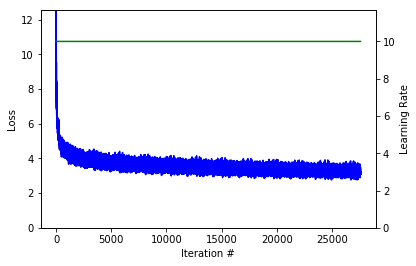

Epoch 12/25 batches: 2250/2326 lr 10.00, loss 3.31, perplexity: 27.30


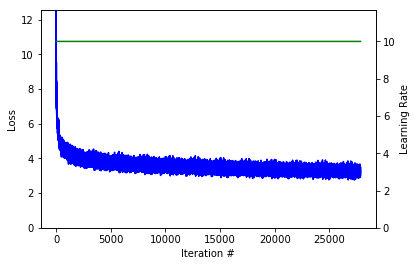

Epoch  12 results: time: 329.09s, validation loss  3.59, perplexity    36.32
Epoch 13/25 batches: 250/2326 lr 10.00, loss 3.28, perplexity: 26.70


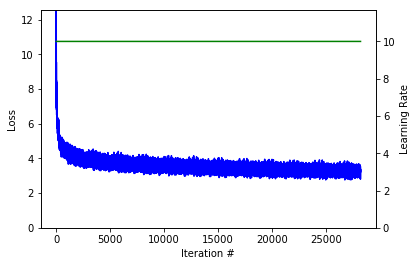

Epoch 13/25 batches: 500/2326 lr 10.00, loss 3.23, perplexity: 25.19


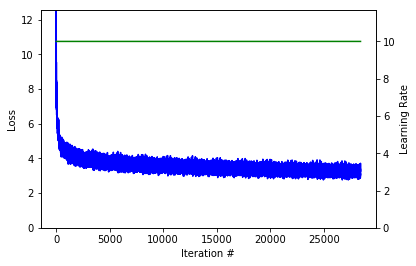

Epoch 13/25 batches: 750/2326 lr 10.00, loss 3.29, perplexity: 26.91


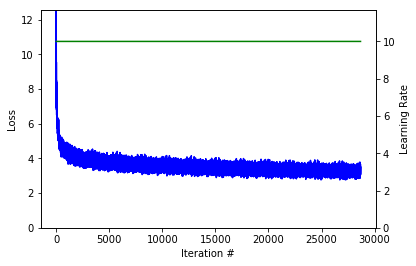

Epoch 13/25 batches: 1000/2326 lr 10.00, loss 3.27, perplexity: 26.35


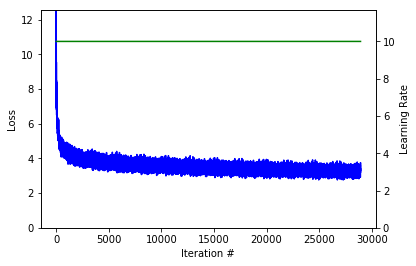

Epoch 13/25 batches: 1250/2326 lr 10.00, loss 3.29, perplexity: 26.78


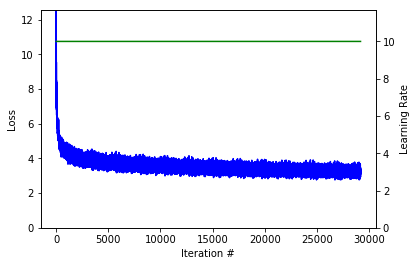

Epoch 13/25 batches: 1500/2326 lr 10.00, loss 3.27, perplexity: 26.35


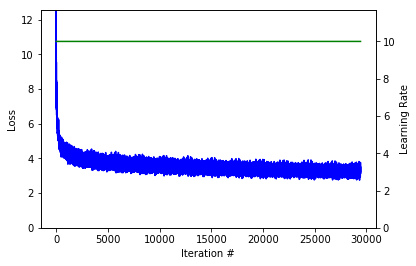

Epoch 13/25 batches: 1750/2326 lr 10.00, loss 3.24, perplexity: 25.52


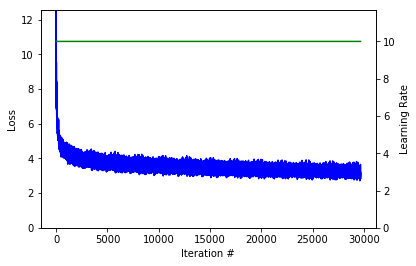

Epoch 13/25 batches: 2000/2326 lr 10.00, loss 3.24, perplexity: 25.51


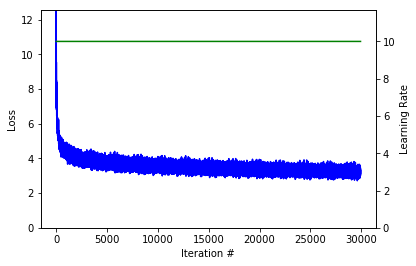

Epoch 13/25 batches: 2250/2326 lr 10.00, loss 3.28, perplexity: 26.61


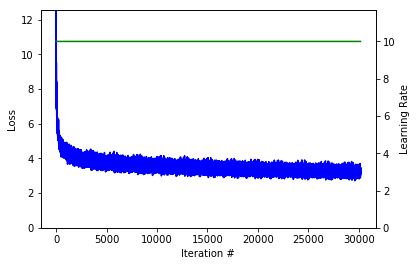

Epoch  13 results: time: 330.36s, validation loss  3.59, perplexity    36.28
Epoch 14/25 batches: 250/2326 lr 10.00, loss 3.26, perplexity: 26.10


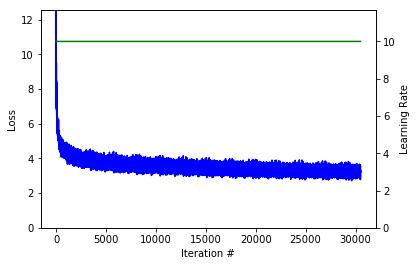

Epoch 14/25 batches: 500/2326 lr 10.00, loss 3.20, perplexity: 24.59


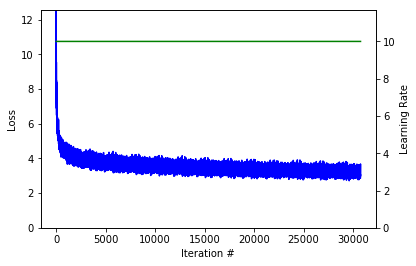

Epoch 14/25 batches: 750/2326 lr 10.00, loss 3.27, perplexity: 26.29


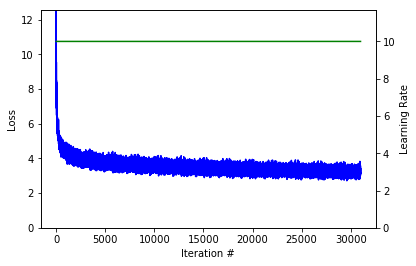

Epoch 14/25 batches: 1000/2326 lr 10.00, loss 3.24, perplexity: 25.65


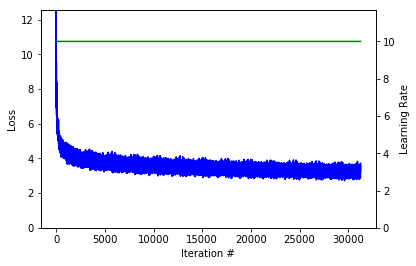

Epoch 14/25 batches: 1250/2326 lr 10.00, loss 3.27, perplexity: 26.21


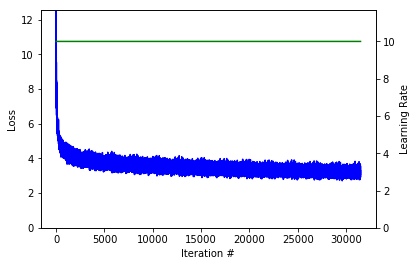

Epoch 14/25 batches: 1500/2326 lr 10.00, loss 3.25, perplexity: 25.71


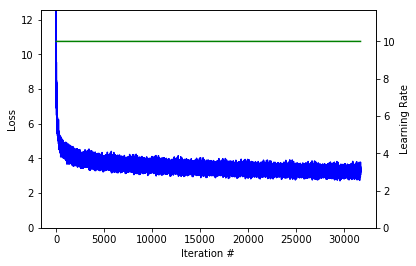

Epoch 14/25 batches: 1750/2326 lr 10.00, loss 3.22, perplexity: 24.94


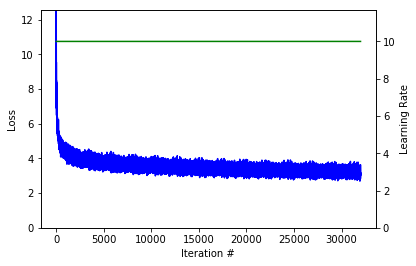

Epoch 14/25 batches: 2000/2326 lr 10.00, loss 3.22, perplexity: 24.98


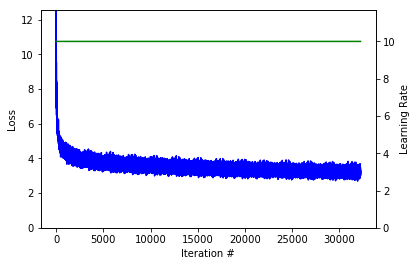

Epoch 14/25 batches: 2250/2326 lr 10.00, loss 3.26, perplexity: 26.07


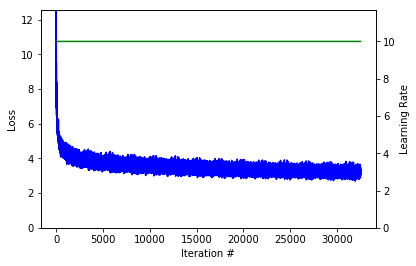

Epoch  14 results: time: 330.96s, validation loss  3.59, perplexity    36.22
Epoch 15/25 batches: 250/2326 lr 10.00, loss 3.24, perplexity: 25.50


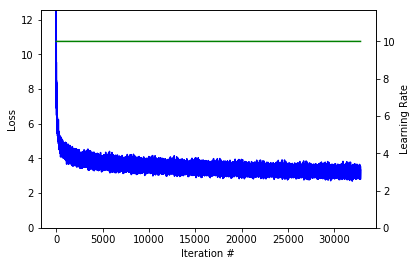

Epoch 15/25 batches: 500/2326 lr 10.00, loss 3.18, perplexity: 24.03


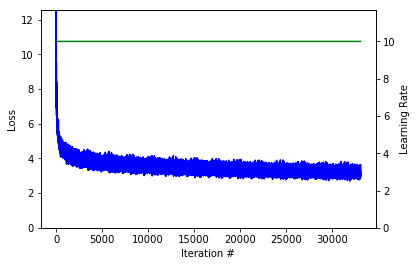

Epoch 15/25 batches: 750/2326 lr 10.00, loss 3.25, perplexity: 25.72


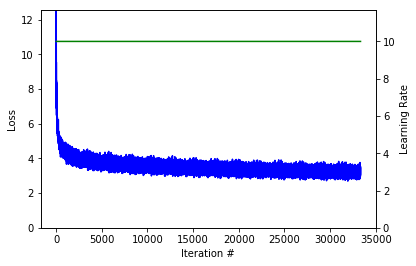

Epoch 15/25 batches: 1000/2326 lr 10.00, loss 3.22, perplexity: 25.02


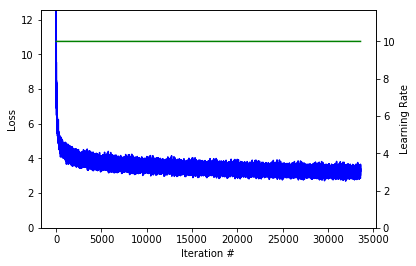

Epoch 15/25 batches: 1250/2326 lr 10.00, loss 3.24, perplexity: 25.55


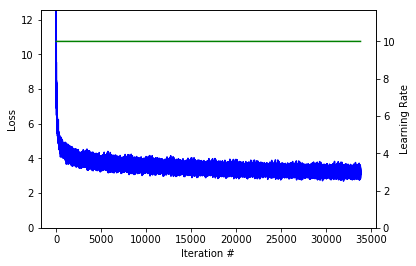

Epoch 15/25 batches: 1500/2326 lr 10.00, loss 3.22, perplexity: 25.12


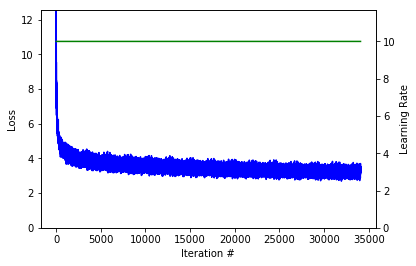

Epoch 15/25 batches: 1750/2326 lr 10.00, loss 3.19, perplexity: 24.37


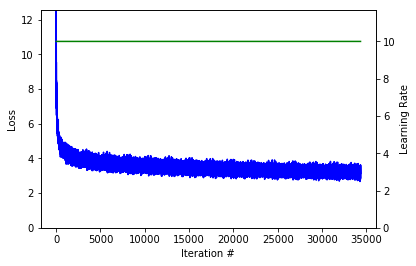

Epoch 15/25 batches: 2000/2326 lr 10.00, loss 3.20, perplexity: 24.44


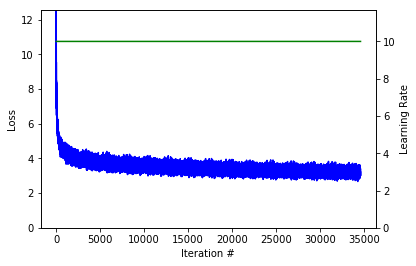

Epoch 15/25 batches: 2250/2326 lr 10.00, loss 3.24, perplexity: 25.42


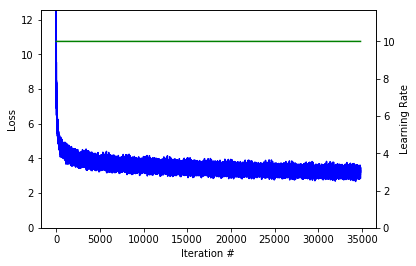

Epoch  15 results: time: 331.08s, validation loss  3.59, perplexity    36.16
Epoch 16/25 batches: 250/2326 lr 10.00, loss 3.21, perplexity: 24.90


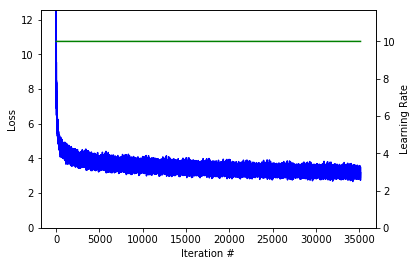

Epoch 16/25 batches: 500/2326 lr 10.00, loss 3.16, perplexity: 23.46


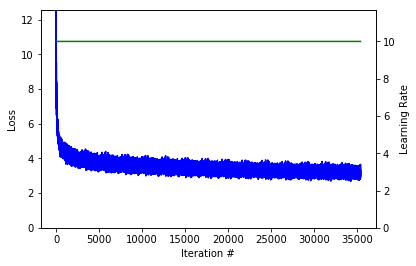

Epoch 16/25 batches: 750/2326 lr 10.00, loss 3.22, perplexity: 25.13


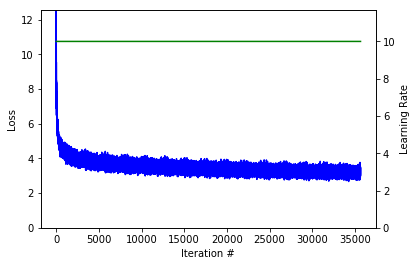

Epoch 16/25 batches: 1000/2326 lr 10.00, loss 3.20, perplexity: 24.45


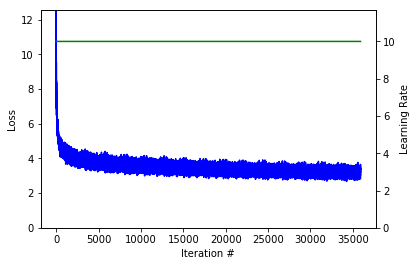

Epoch 16/25 batches: 1250/2326 lr 10.00, loss 3.22, perplexity: 25.04


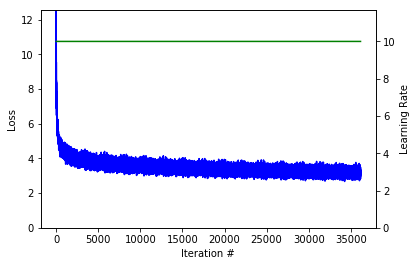

Epoch 16/25 batches: 1500/2326 lr 10.00, loss 3.20, perplexity: 24.65


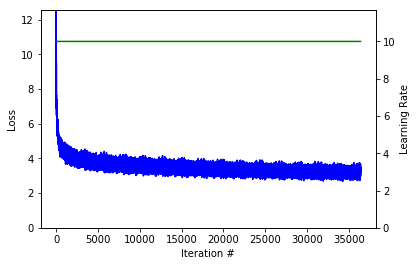

Epoch 16/25 batches: 1750/2326 lr 10.00, loss 3.17, perplexity: 23.81


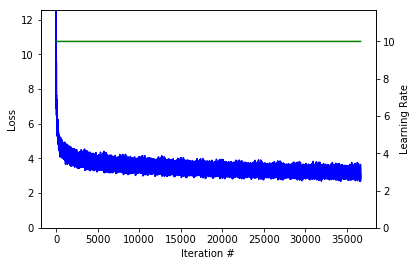

Epoch 16/25 batches: 2000/2326 lr 10.00, loss 3.18, perplexity: 23.94


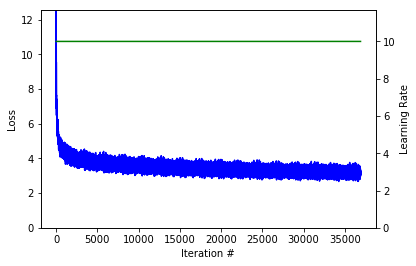

Epoch 16/25 batches: 2250/2326 lr 10.00, loss 3.21, perplexity: 24.89


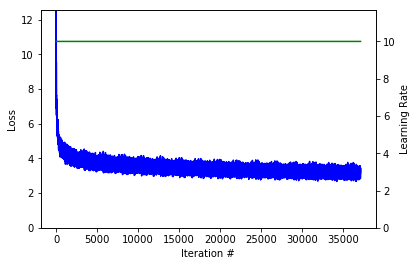

Epoch  16 results: time: 331.66s, validation loss  3.59, perplexity    36.11
Epoch 17/25 batches: 250/2326 lr 10.00, loss 3.20, perplexity: 24.43


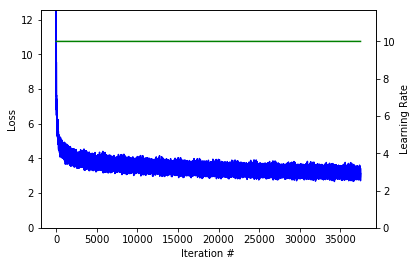

Epoch 17/25 batches: 500/2326 lr 10.00, loss 3.14, perplexity: 23.08


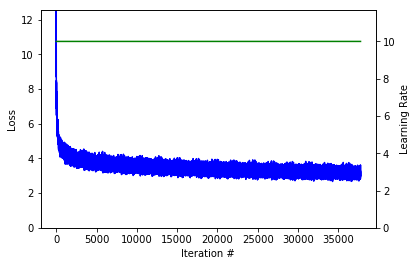

Epoch 17/25 batches: 750/2326 lr 10.00, loss 3.20, perplexity: 24.60


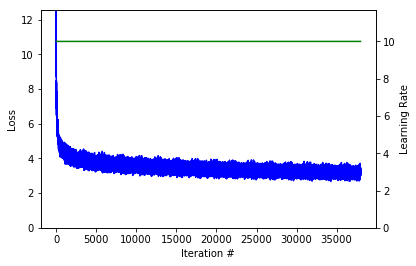

Epoch 17/25 batches: 1000/2326 lr 10.00, loss 3.18, perplexity: 24.05


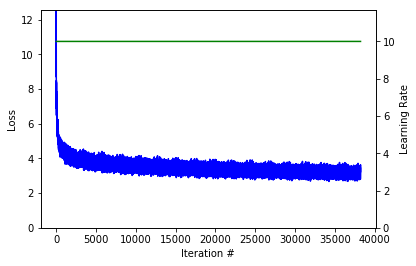

Epoch 17/25 batches: 1250/2326 lr 10.00, loss 3.20, perplexity: 24.56


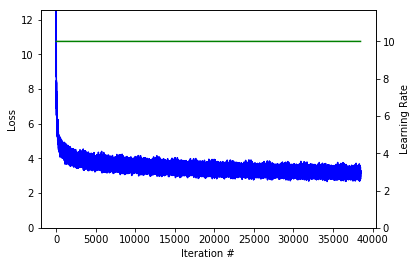

Epoch 17/25 batches: 1500/2326 lr 10.00, loss 3.18, perplexity: 24.14


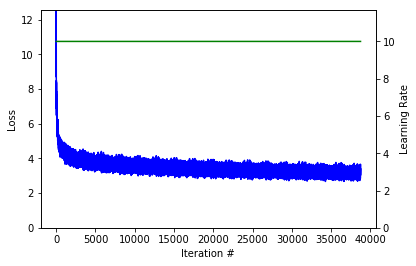

Epoch 17/25 batches: 1750/2326 lr 10.00, loss 3.15, perplexity: 23.45


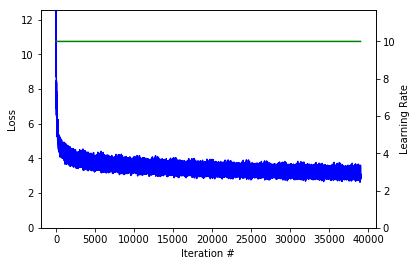

Epoch 17/25 batches: 2000/2326 lr 10.00, loss 3.16, perplexity: 23.47


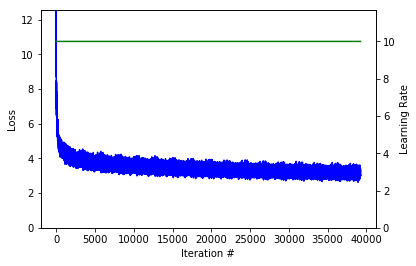

Epoch 17/25 batches: 2250/2326 lr 10.00, loss 3.19, perplexity: 24.34


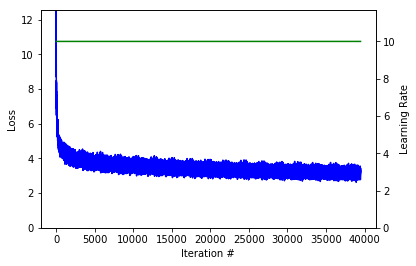

Epoch  17 results: time: 331.75s, validation loss  3.59, perplexity    36.11
Epoch 18/25 batches: 250/2326 lr 2.50, loss 3.17, perplexity: 23.83


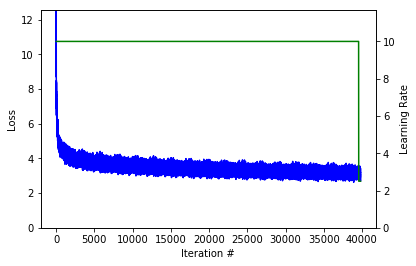

Epoch 18/25 batches: 500/2326 lr 2.50, loss 3.10, perplexity: 22.16


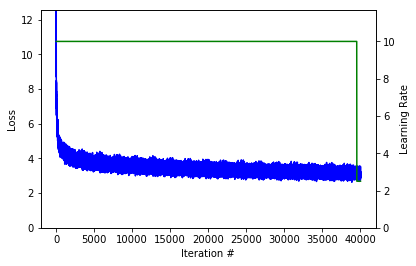

Epoch 18/25 batches: 750/2326 lr 2.50, loss 3.15, perplexity: 23.37


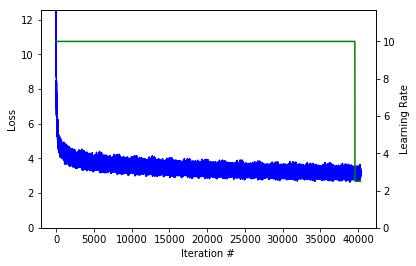

Epoch 18/25 batches: 1000/2326 lr 2.50, loss 3.11, perplexity: 22.52


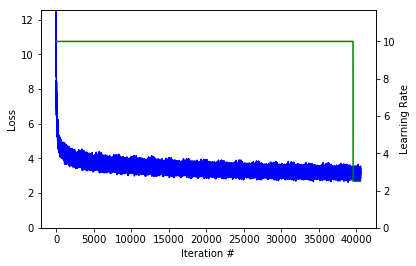

Epoch 18/25 batches: 1250/2326 lr 2.50, loss 3.12, perplexity: 22.73


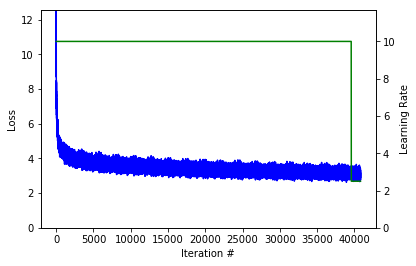

Epoch 18/25 batches: 1500/2326 lr 2.50, loss 3.10, perplexity: 22.24


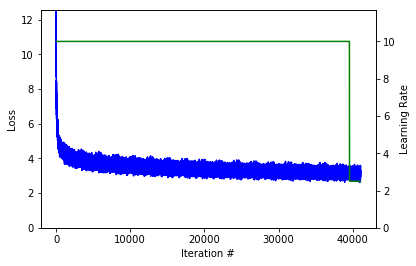

Epoch 18/25 batches: 1750/2326 lr 2.50, loss 3.06, perplexity: 21.31


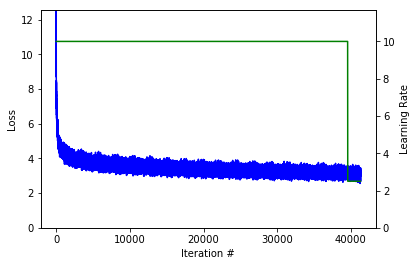

Epoch 18/25 batches: 2000/2326 lr 2.50, loss 3.05, perplexity: 21.22


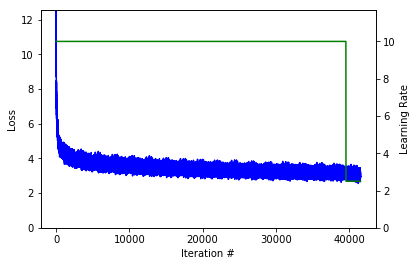

Epoch 18/25 batches: 2250/2326 lr 2.50, loss 3.08, perplexity: 21.77


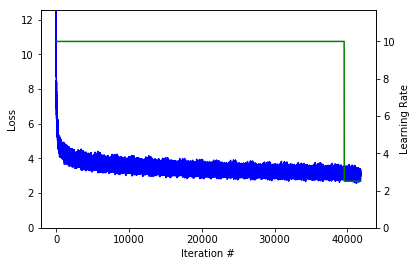

Epoch  18 results: time: 331.58s, validation loss  3.57, perplexity    35.51
Epoch 19/25 batches: 250/2326 lr 2.50, loss 3.12, perplexity: 22.62


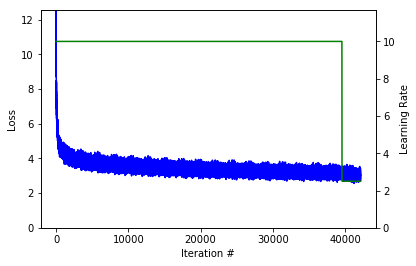

Epoch 19/25 batches: 500/2326 lr 2.50, loss 3.06, perplexity: 21.25


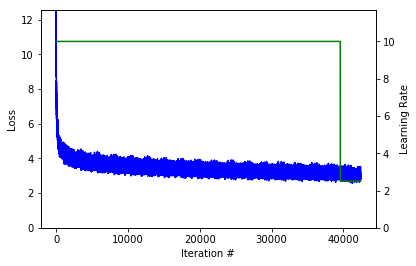

Epoch 19/25 batches: 750/2326 lr 2.50, loss 3.11, perplexity: 22.51


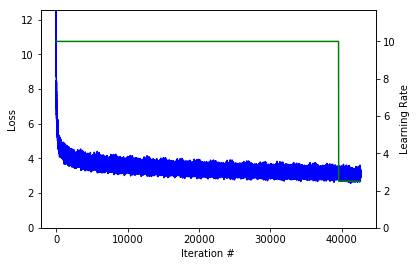

Epoch 19/25 batches: 1000/2326 lr 2.50, loss 3.08, perplexity: 21.80


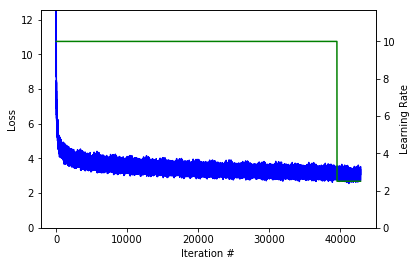

Epoch 19/25 batches: 1250/2326 lr 2.50, loss 3.10, perplexity: 22.13


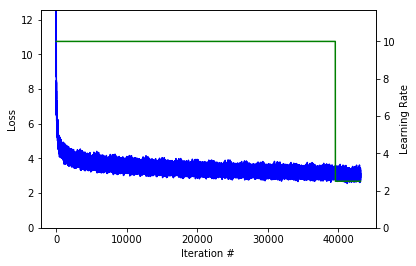

Epoch 19/25 batches: 1500/2326 lr 2.50, loss 3.08, perplexity: 21.74


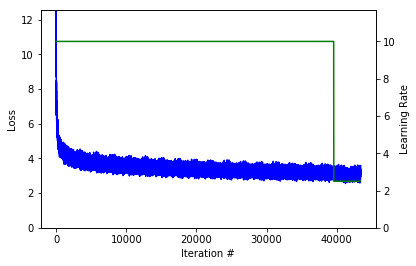

Epoch 19/25 batches: 1750/2326 lr 2.50, loss 3.04, perplexity: 20.83


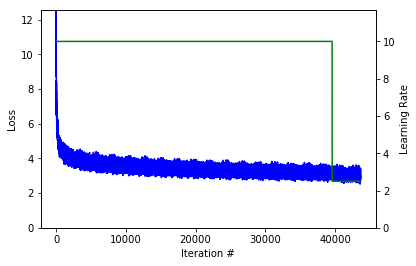

Epoch 19/25 batches: 2000/2326 lr 2.50, loss 3.03, perplexity: 20.77


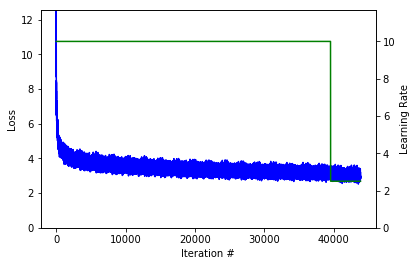

Epoch 19/25 batches: 2250/2326 lr 2.50, loss 3.07, perplexity: 21.48


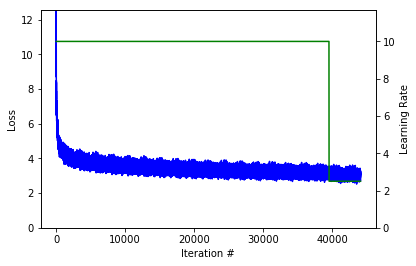

Epoch  19 results: time: 331.47s, validation loss  3.57, perplexity    35.50
Epoch 20/25 batches: 250/2326 lr 2.50, loss 3.09, perplexity: 22.05


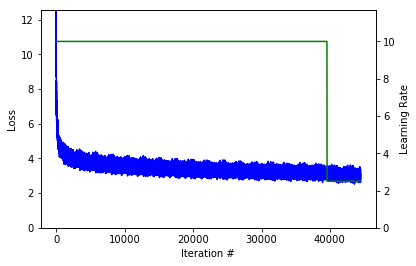

Epoch 20/25 batches: 500/2326 lr 2.50, loss 3.03, perplexity: 20.77


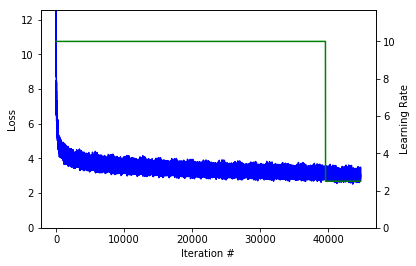

Epoch 20/25 batches: 750/2326 lr 2.50, loss 3.09, perplexity: 21.99


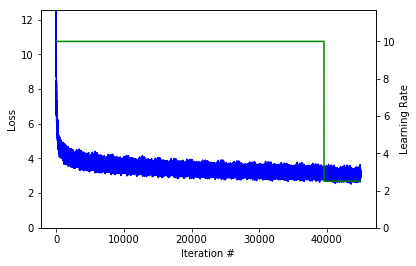

Epoch 20/25 batches: 1000/2326 lr 2.50, loss 3.07, perplexity: 21.43


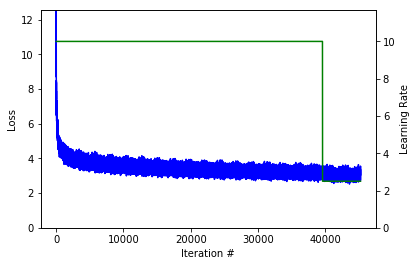

Epoch 20/25 batches: 1250/2326 lr 2.50, loss 3.08, perplexity: 21.76


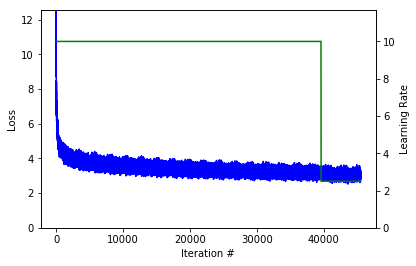

Epoch 20/25 batches: 1500/2326 lr 2.50, loss 3.06, perplexity: 21.33


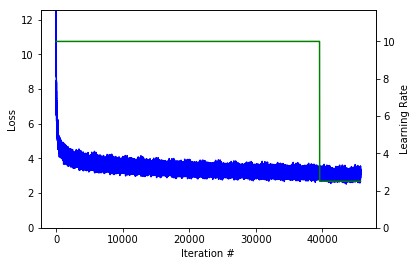

Epoch 20/25 batches: 1750/2326 lr 2.50, loss 3.03, perplexity: 20.64


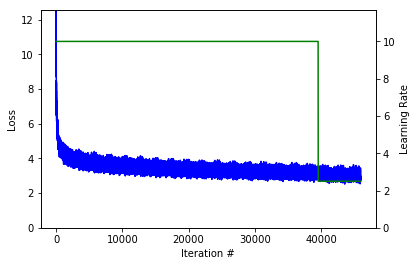

Epoch 20/25 batches: 2000/2326 lr 2.50, loss 3.02, perplexity: 20.54


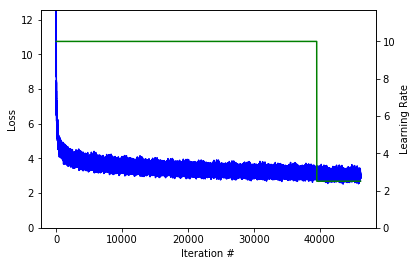

Epoch 20/25 batches: 2250/2326 lr 2.50, loss 3.06, perplexity: 21.25


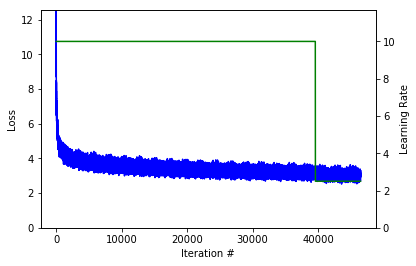

Epoch  20 results: time: 331.72s, validation loss  3.57, perplexity    35.54
Epoch 21/25 batches: 250/2326 lr 0.62, loss 3.09, perplexity: 21.89


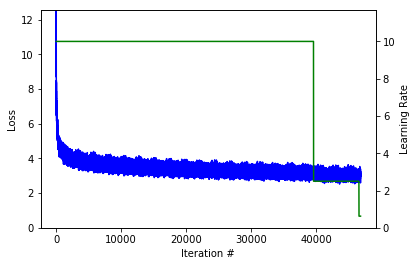

Epoch 21/25 batches: 500/2326 lr 0.62, loss 3.02, perplexity: 20.53


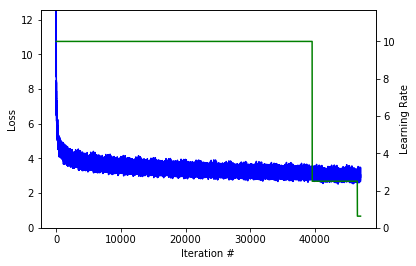

Epoch 21/25 batches: 750/2326 lr 0.62, loss 3.09, perplexity: 21.87


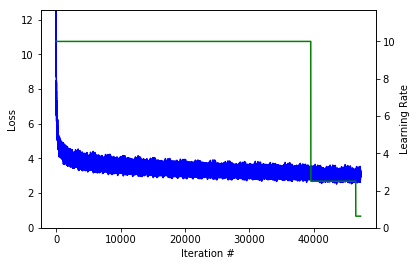

Epoch 21/25 batches: 1000/2326 lr 0.62, loss 3.05, perplexity: 21.16


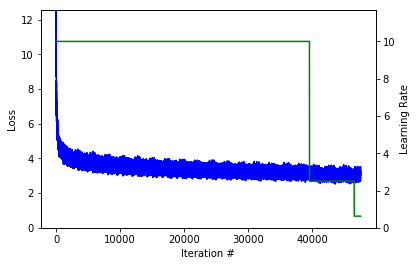

Epoch 21/25 batches: 1250/2326 lr 0.62, loss 3.07, perplexity: 21.45


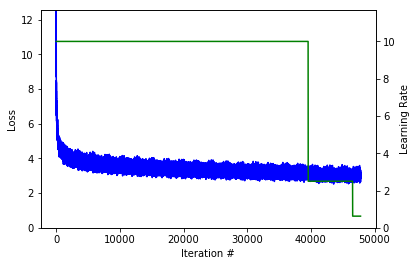

Epoch 21/25 batches: 1500/2326 lr 0.62, loss 3.04, perplexity: 20.95


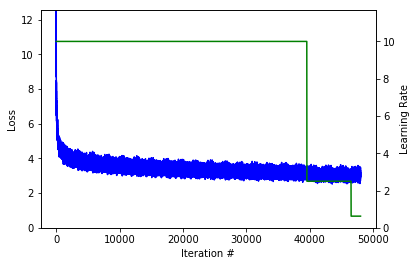

Epoch 21/25 batches: 1750/2326 lr 0.62, loss 3.00, perplexity: 20.10


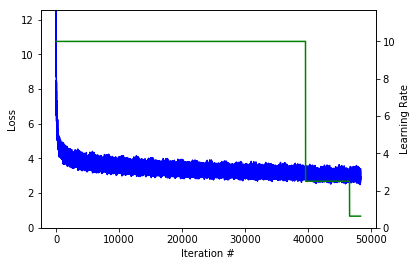

Epoch 21/25 batches: 2000/2326 lr 0.62, loss 3.00, perplexity: 20.05


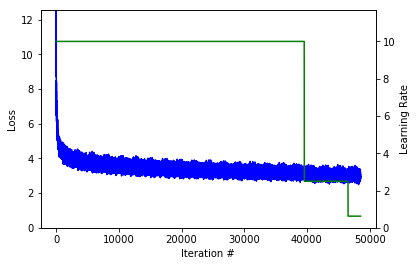

Epoch 21/25 batches: 2250/2326 lr 0.62, loss 3.03, perplexity: 20.63


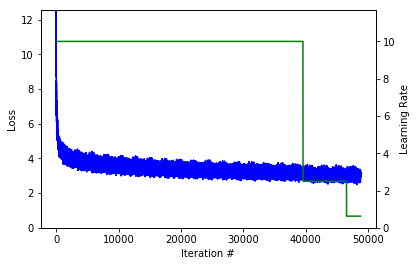

Epoch  21 results: time: 331.69s, validation loss  3.56, perplexity    35.33
Epoch 22/25 batches: 250/2326 lr 0.62, loss 3.07, perplexity: 21.64


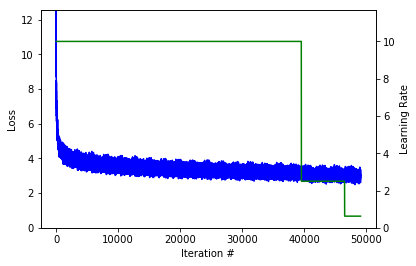

Epoch 22/25 batches: 500/2326 lr 0.62, loss 3.01, perplexity: 20.28


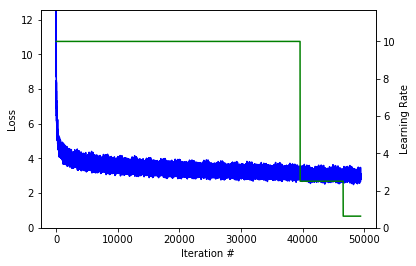

Epoch 22/25 batches: 750/2326 lr 0.62, loss 3.07, perplexity: 21.53


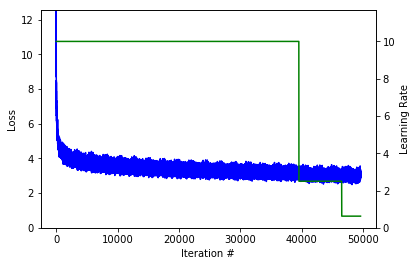

Epoch 22/25 batches: 1000/2326 lr 0.62, loss 3.05, perplexity: 21.03


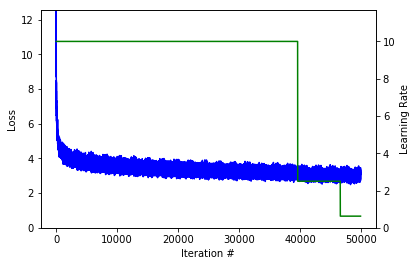

Epoch 22/25 batches: 1250/2326 lr 0.62, loss 3.06, perplexity: 21.22


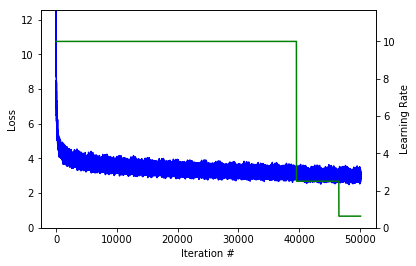

Epoch 22/25 batches: 1500/2326 lr 0.62, loss 3.04, perplexity: 20.85


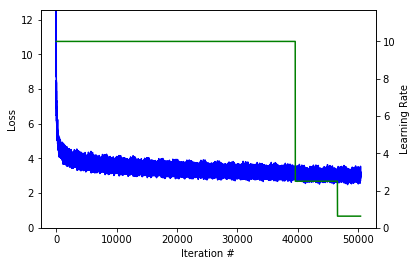

Epoch 22/25 batches: 1750/2326 lr 0.62, loss 3.00, perplexity: 19.99


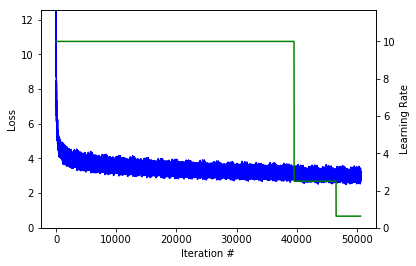

Epoch 22/25 batches: 2000/2326 lr 0.62, loss 2.99, perplexity: 19.90


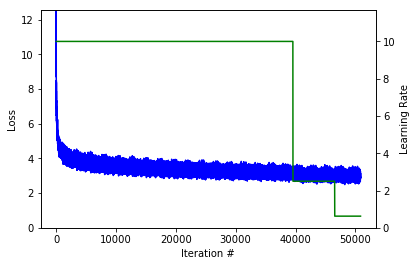

Epoch 22/25 batches: 2250/2326 lr 0.62, loss 3.02, perplexity: 20.57


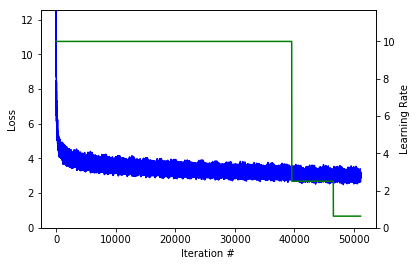

Epoch  22 results: time: 331.59s, validation loss  3.56, perplexity    35.30
Epoch 23/25 batches: 250/2326 lr 0.62, loss 3.06, perplexity: 21.42


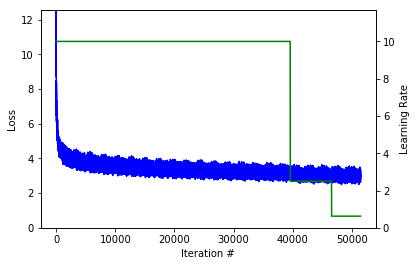

Epoch 23/25 batches: 500/2326 lr 0.62, loss 3.00, perplexity: 20.15


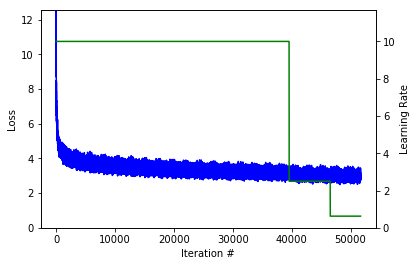

Epoch 23/25 batches: 750/2326 lr 0.62, loss 3.06, perplexity: 21.36


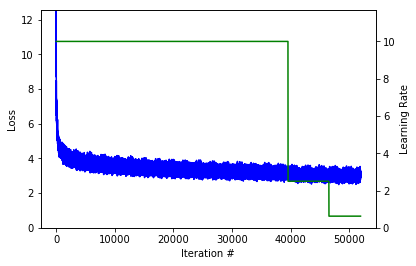

Epoch 23/25 batches: 1000/2326 lr 0.62, loss 3.04, perplexity: 20.83


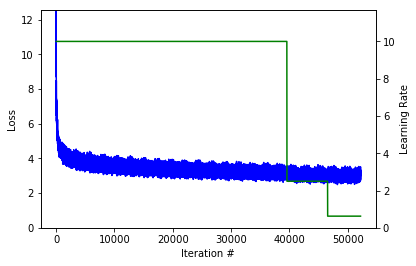

Epoch 23/25 batches: 1250/2326 lr 0.62, loss 3.05, perplexity: 21.11


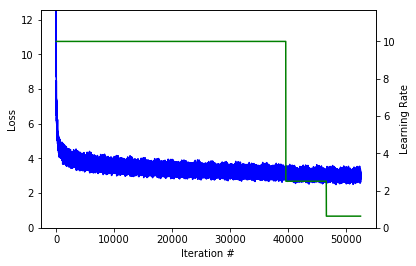

Epoch 23/25 batches: 1500/2326 lr 0.62, loss 3.03, perplexity: 20.65


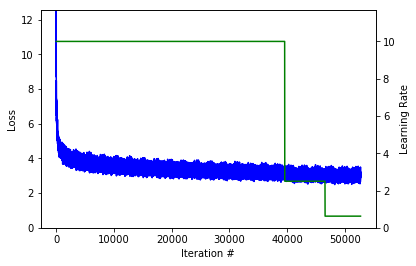

Epoch 23/25 batches: 1750/2326 lr 0.62, loss 2.99, perplexity: 19.89


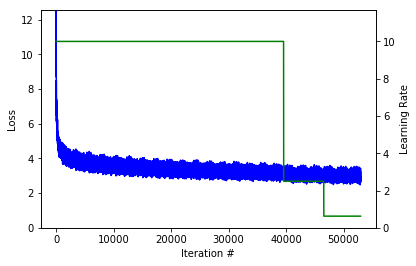

Epoch 23/25 batches: 2000/2326 lr 0.62, loss 2.99, perplexity: 19.83


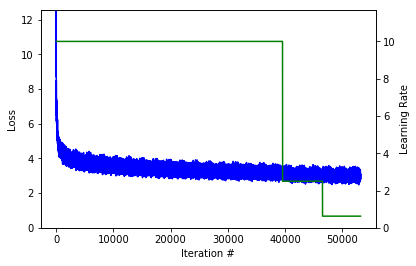

Epoch 23/25 batches: 2250/2326 lr 0.62, loss 3.02, perplexity: 20.46


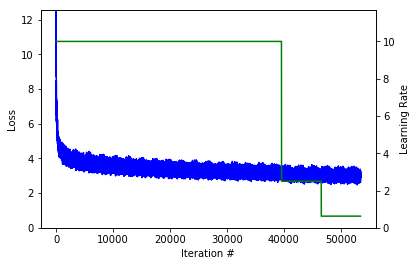

Epoch  23 results: time: 331.59s, validation loss  3.56, perplexity    35.31
Epoch 24/25 batches: 250/2326 lr 0.16, loss 3.07, perplexity: 21.53


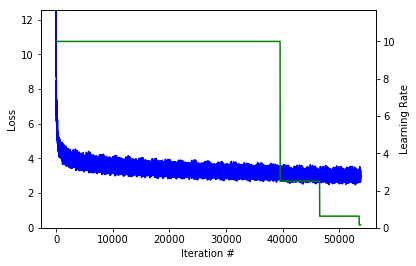

Epoch 24/25 batches: 500/2326 lr 0.16, loss 3.01, perplexity: 20.21


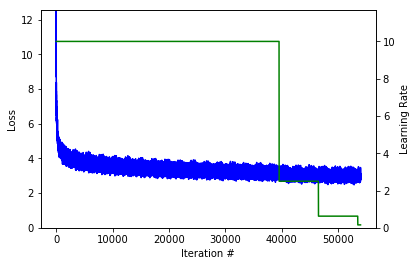

Epoch 24/25 batches: 750/2326 lr 0.16, loss 3.06, perplexity: 21.38


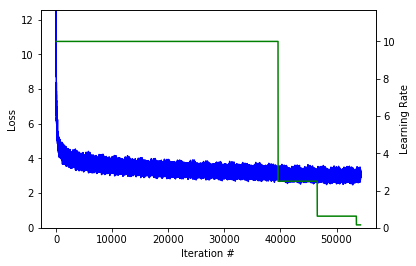

Epoch 24/25 batches: 1000/2326 lr 0.16, loss 3.04, perplexity: 20.89


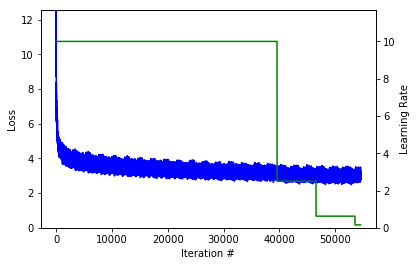

Epoch 24/25 batches: 1250/2326 lr 0.16, loss 3.05, perplexity: 21.03


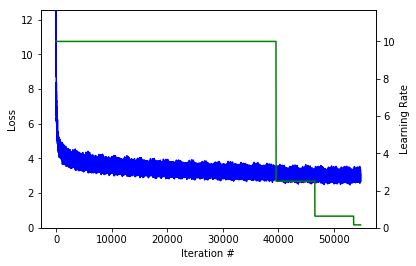

Epoch 24/25 batches: 1500/2326 lr 0.16, loss 3.03, perplexity: 20.63


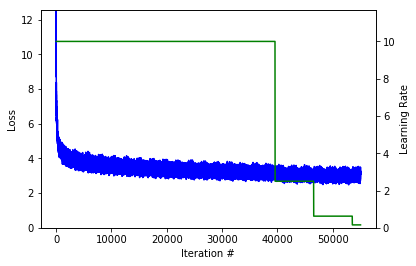

Epoch 24/25 batches: 1750/2326 lr 0.16, loss 2.99, perplexity: 19.82


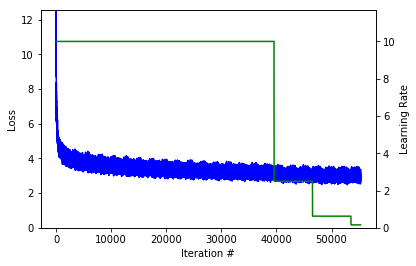

Epoch 24/25 batches: 2000/2326 lr 0.16, loss 2.98, perplexity: 19.67


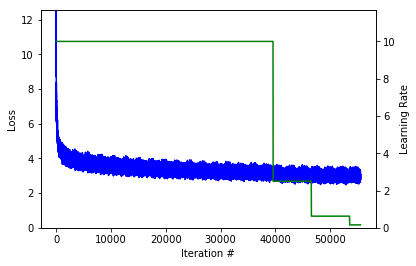

Epoch 24/25 batches: 2250/2326 lr 0.16, loss 3.01, perplexity: 20.36


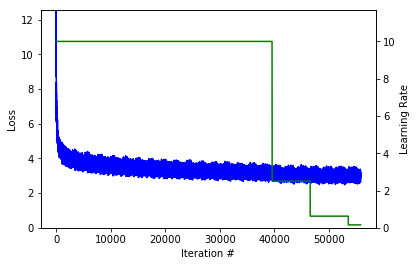

Epoch  24 results: time: 332.02s, validation loss  3.56, perplexity    35.17
Epoch 25/25 batches: 250/2326 lr 0.16, loss 3.06, perplexity: 21.36


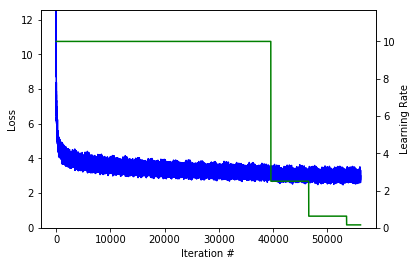

Epoch 25/25 batches: 500/2326 lr 0.16, loss 3.00, perplexity: 20.00


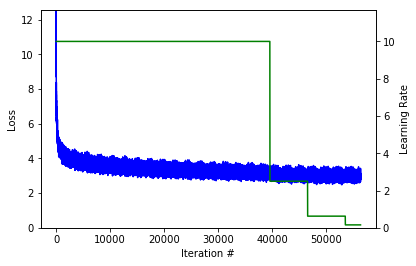

Epoch 25/25 batches: 750/2326 lr 0.16, loss 3.06, perplexity: 21.32


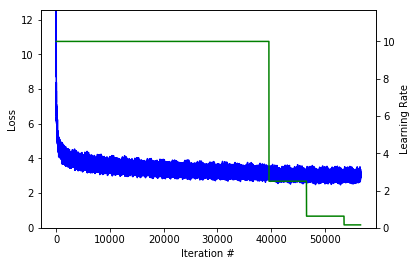

Epoch 25/25 batches: 1000/2326 lr 0.16, loss 3.03, perplexity: 20.71


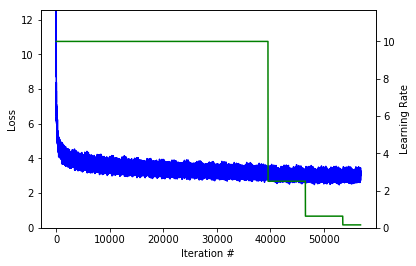

Epoch 25/25 batches: 1250/2326 lr 0.16, loss 3.04, perplexity: 20.97


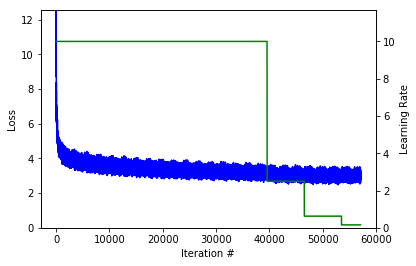

Epoch 25/25 batches: 1500/2326 lr 0.16, loss 3.02, perplexity: 20.53


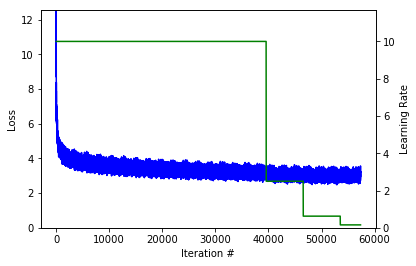

Epoch 25/25 batches: 1750/2326 lr 0.16, loss 2.99, perplexity: 19.91


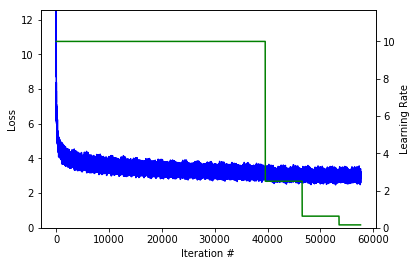

Epoch 25/25 batches: 2000/2326 lr 0.16, loss 2.98, perplexity: 19.69


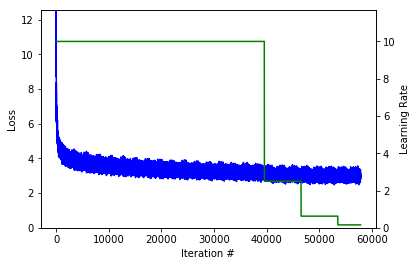

Epoch 25/25 batches: 2250/2326 lr 0.16, loss 3.01, perplexity: 20.32


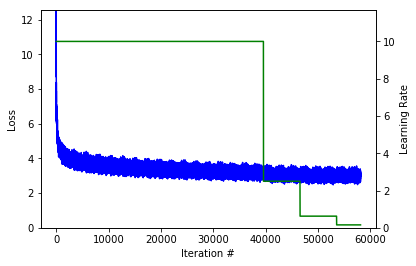

Epoch  25 results: time: 331.59s, validation loss  3.56, perplexity    35.15


/home/tyson/anaconda3/envs/ml/lib/python3.6/site-packages/ipykernel/__main__.py:41: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greately increasing memory usage. To compact weights again call flatten_parameters().


/n End of training. Test loss:  3.60, Test perplexity:    36.64


In [17]:
# At any point we can hit Ctrl+C to break out of training early
try:
    train()
except KeyboardInterrupt:
    print('='*75)
    print('Exiting from training early')
    
# Load the best saved model
with open('model_checkpoint.pt', 'rb') as f:
    model = torch.load(f)

# Run on the test data
test_loss = evaluate(test_data)
print('='*75)
print('/n End of training. Test loss: {:5.2f}, Test perplexity: {:8.2f}'.format(
    test_loss, math.exp(test_loss)
))
print('='*75)

## Generate Sample Output
Now that we've trained our model, we can generate new sentences from our model

In [18]:
random_seed = 421
num_output_words = 550

In [19]:
torch.manual_seed(random_seed)

if GPU_AVAILABLE:
    torch.cuda.manual_seed(random_seed)

with open('model_checkpoint.pt', 'rb') as f:
    model = torch.load(f)

model.eval()

if GPU_AVAILABLE:
    model.cuda()
else:
    model.cpu()

corpus = Corpus(pathname)
n_tokens = len(corpus.dictionary)
hidden = model.init_hidden(1)
input = Variable(torch.rand(1, 1).mul(n_tokens).long(), volatile=True)

if GPU_AVAILABLE:
    input.data = input.data.cuda()

def get_token_map():
    return {v: k for k, v in token_lookup().items()}

with open('output.txt', 'w') as outf:
    for i in range(num_output_words):
        output, hidden = model(input, hidden)
        word_weights = output.squeeze().data.exp().cpu()
        word_idx = torch.multinomial(word_weights, 1)[0]
        input.data.fill_(word_idx)
        word = corpus.dictionary.idx_to_word[word_idx]
        
        token_map = get_token_map()
        is_token = False
        
        if token_map.get(word):
            is_token = True
            word = token_map[word]
            
        outf.write(('' if is_token else ' ') + word)
        
        if i % logging_interval == 0:
            print('Generated {}/{} words'.format(i, num_output_words))

Generated 0/550 words
Generated 250/550 words
Generated 500/550 words


In [20]:
%%bash
cat ./output.txt

 uniform and the grant came after the popularity of dumping business.

 lisa simpson: dad, you tried the babysitter.

 homer simpson:( embarrassed) who else?

 lisa simpson: mom, they know what corey' s saying.

 bart simpson: i' m in the way to resist it.

 homer simpson: mmmm, you don' t understand mrs. tail. look at my mom!

 homer simpson: lives by our trompe.

 homer simpson: don' t worry, darling. you can' t be twelve. i can' t win!

 homer simpson:( correcting) you! you' ll be ahead of ya.

 marge simpson: homer, you' re just trying to feel funny.

 homer simpson: son, maybe we' re saved!

 bart simpson: dad, in these years, i wanna experience the best i snuck in.

 homer simpson:( feisty) barney, i could win a break on the factory! you brush the car where we' re about your ear leprechaun!

 homer simpson:( nodding sarcasm) why is that type in the bathtub' s deadliest lung?

 lisa simpson: better drive the plug.

 grampa simpson: this was all my room.

 bart simpson: this is no 

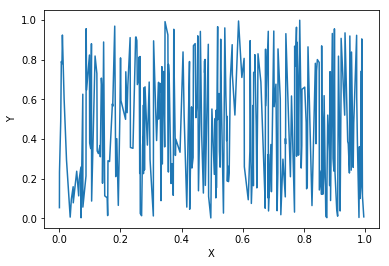

In [21]:
import matplotlib.pyplot as plt
import numpy
import math

x = numpy.random.rand(300)
y = numpy.random.rand(300)
x = numpy.sort(x, 0)
# y = numpy.sort(y, 0)

plt.plot(x, y)
plt.ylabel('Y')
plt.xlabel('X')
plt.show()
    